In [1]:
import covidcast
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%cd ../code
from model import Model, ModelGamma

%cd ../notebooks

/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/code
/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/notebooks


In [2]:
#Load data
start_date = datetime(2020, 10, 15)
end_date = datetime(2020, 12, 15)
    
X_df = covidcast.signal(
        'fb-survey', 
        'smoothed_cli',
        start_date, end_date,
        geo_type='state')

Y_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='state')

In [3]:
#Process data for use in Tensorflow
states = ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

df = X_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
X = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
X = tf.transpose(X, perm=[1,0])
X = tf.expand_dims(X,axis=0) #shape=(1,time series values, number of geo_values)
X = tf.cast(X, dtype=tf.float32)

df = Y_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
Y = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
Y = tf.transpose(Y, perm=[1,0])
Y = tf.expand_dims(Y,axis=0) #shape=(1, time series values, number of geo_values)
Y = tf.cast(Y, dtype=tf.float32)

In [4]:
#Initialize model without filter bank

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
lr = 0.001

model_a = ModelGamma(
    p = p, 
    m = m,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam=1,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_A_PATH = "model_a.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_A_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_a.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [5]:
#Training
hist = model_a.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
   epochs = 10000,
)

Epoch 1/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15580805.0000
Epoch 2/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580803.0000
Epoch 3/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15580801.0000
Epoch 4/10000
1/1 [==============================] - 0s 723us/step - MSE: 15580801.0000
Epoch 5/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580800.0000
Epoch 6/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15580797.0000
Epoch 7/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580796.0000
Epoch 8/10000
1/1 [==============================] - 0s 25ms/step - MSE: 15580794.0000
Epoch 9/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580793.0000
Epoch 10/10000
1/1 [==============================] - 0s 24ms/step - MSE: 15580790.0000
Epoch 11/10000
1/1 [==============================] - 0s 29ms/step - MSE: 15580789.0000
Epoch 12/10000
1/1 [====================

1/1 [==============================] - 0s 21ms/step - MSE: 15580632.0000
Epoch 95/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580629.0000
Epoch 96/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15580628.0000
Epoch 97/10000
1/1 [==============================] - 0s 24ms/step - MSE: 15580625.0000
Epoch 98/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580622.0000
Epoch 99/10000
1/1 [==============================] - 0s 498us/step - MSE: 15580622.0000
Epoch 100/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580620.0000
Epoch 101/10000
1/1 [==============================] - 0s 18ms/step - MSE: 15580616.0000
Epoch 102/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580615.0000
Epoch 103/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580612.0000
Epoch 104/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580609.0000
Epoch 105/10000
1/1 [====================

1/1 [==============================] - 0s 19ms/step - MSE: 15580391.0000
Epoch 187/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580387.0000
Epoch 188/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580383.0000
Epoch 189/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580379.0000
Epoch 190/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580378.0000
Epoch 191/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580374.0000
Epoch 192/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580370.0000
Epoch 193/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580367.0000
Epoch 194/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580365.0000
Epoch 195/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580361.0000
Epoch 196/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15580358.0000
Epoch 197/10000
1/1 [================

1/1 [==============================] - 0s 24ms/step - MSE: 15580033.0000
Epoch 279/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15580028.0000
Epoch 280/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580023.0000
Epoch 281/10000
1/1 [==============================] - 0s 18ms/step - MSE: 15580017.0000
Epoch 282/10000
1/1 [==============================] - 0s 18ms/step - MSE: 15580012.0000
Epoch 283/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580007.0000
Epoch 284/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15580003.0000
Epoch 285/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15579996.0000
Epoch 286/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15579992.0000
Epoch 287/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15579986.0000
Epoch 288/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15579982.0000
Epoch 289/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 15579439.0000
Epoch 371/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15579431.0000
Epoch 372/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15579423.0000
Epoch 373/10000
1/1 [==============================] - 0s 23ms/step - MSE: 15579413.0000
Epoch 374/10000
1/1 [==============================] - 0s 23ms/step - MSE: 15579404.0000
Epoch 375/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15579396.0000
Epoch 376/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15579388.0000
Epoch 377/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15579378.0000
Epoch 378/10000
1/1 [==============================] - 0s 18ms/step - MSE: 15579370.0000
Epoch 379/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15579362.0000
Epoch 380/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15579351.0000
Epoch 381/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 15578309.0000
Epoch 463/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578292.0000
Epoch 464/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578272.0000
Epoch 465/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578255.0000
Epoch 466/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578238.0000
Epoch 467/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578219.0000
Epoch 468/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578201.0000
Epoch 469/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578182.0000
Epoch 470/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578161.0000
Epoch 471/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15578142.0000
Epoch 472/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15578124.0000
Epoch 473/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 15575563.0000
Epoch 555/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15575513.0000
Epoch 556/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575463.0000
Epoch 557/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575413.0000
Epoch 558/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575360.0000
Epoch 559/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575310.0000
Epoch 560/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575255.0000
Epoch 561/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575201.0000
Epoch 562/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575146.0000
Epoch 563/10000
1/1 [==============================] - 0s 18ms/step - MSE: 15575093.0000
Epoch 564/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15575035.0000
Epoch 565/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 15565151.0000
Epoch 647/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15564908.0000
Epoch 648/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15564660.0000
Epoch 649/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15564406.0000
Epoch 650/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15564145.0000
Epoch 651/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15563880.0000
Epoch 652/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15563608.0000
Epoch 653/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15563328.0000
Epoch 654/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15563045.0000
Epoch 655/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15562752.0000
Epoch 656/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15562455.0000
Epoch 657/10000
1/1 [================

1/1 [==============================] - 0s 21ms/step - MSE: 15453430.0000
Epoch 739/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15448973.0000
Epoch 740/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15444304.0000
Epoch 741/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15439419.0000
Epoch 742/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15434299.0000
Epoch 743/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15428933.0000
Epoch 744/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15423304.0000
Epoch 745/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15417399.0000
Epoch 746/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15411203.0000
Epoch 747/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15404695.0000
Epoch 748/10000
1/1 [==============================] - 0s 19ms/step - MSE: 15397855.0000
Epoch 749/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 2343969.2500
Epoch 831/10000
1/1 [==============================] - 0s 19ms/step - MSE: 2072849.5000
Epoch 832/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1820188.1250
Epoch 833/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1624807.7500
Epoch 834/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1516330.7500
Epoch 835/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1510472.8750
Epoch 836/10000
1/1 [==============================] - 0s 502us/step - MSE: 1594314.8750
Epoch 837/10000
1/1 [==============================] - 0s 465us/step - MSE: 1708050.5000
Epoch 838/10000
1/1 [==============================] - 0s 513us/step - MSE: 1778132.7500
Epoch 839/10000
1/1 [==============================] - 0s 514us/step - MSE: 1776232.5000
Epoch 840/10000
1/1 [==============================] - 0s 455us/step - MSE: 1719832.5000
Epoch 841/10000
1/1 [======================

1/1 [==============================] - 0s 18ms/step - MSE: 1337055.7500
Epoch 924/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1336990.3750
Epoch 925/10000
1/1 [==============================] - 0s 22ms/step - MSE: 1336922.3750
Epoch 926/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1336853.2500
Epoch 927/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1336783.7500
Epoch 928/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1336715.1250
Epoch 929/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1336647.8750
Epoch 930/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1336582.7500
Epoch 931/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1336519.6250
Epoch 932/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1336458.1250
Epoch 933/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1336397.7500
Epoch 934/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 1331155.3750
Epoch 1017/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1331090.6250
Epoch 1018/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1331025.6250
Epoch 1019/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1330960.7500
Epoch 1020/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1330896.0000
Epoch 1021/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1330831.0000
Epoch 1022/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1330766.0000
Epoch 1023/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1330701.0000
Epoch 1024/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1330635.8750
Epoch 1025/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1330570.7500
Epoch 1026/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1330505.6250
Epoch 1027/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1325022.3750
Epoch 1109/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1324954.0000
Epoch 1110/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1324885.3750
Epoch 1111/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1324816.6250
Epoch 1112/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1324748.0000
Epoch 1113/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1324679.2500
Epoch 1114/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1324610.6250
Epoch 1115/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1324541.7500
Epoch 1116/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1324472.8750
Epoch 1117/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1324404.0000
Epoch 1118/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1324335.0000
Epoch 1119/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1318547.1250
Epoch 1201/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1318474.8750
Epoch 1202/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1318402.6250
Epoch 1203/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1318330.2500
Epoch 1204/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1318257.7500
Epoch 1205/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1318185.5000
Epoch 1206/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1318113.0000
Epoch 1207/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1318040.7500
Epoch 1208/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1317968.1250
Epoch 1209/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1317895.6250
Epoch 1210/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1317822.8750
Epoch 1211/10000
1/1 [================

1/1 [==============================] - 0s 21ms/step - MSE: 1311737.8750
Epoch 1293/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1311662.1250
Epoch 1294/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1311586.3750
Epoch 1295/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1311510.5000
Epoch 1296/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1311434.5000
Epoch 1297/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1311358.6250
Epoch 1298/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1311282.5000
Epoch 1299/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1311206.5000
Epoch 1300/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1311130.3750
Epoch 1301/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1311054.2500
Epoch 1302/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1310978.2500
Epoch 1303/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1304605.3750
Epoch 1385/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1304526.0000
Epoch 1386/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1304446.7500
Epoch 1387/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1304367.3750
Epoch 1388/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1304288.0000
Epoch 1389/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1304208.6250
Epoch 1390/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1304129.2500
Epoch 1391/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1304049.7500
Epoch 1392/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1303970.2500
Epoch 1393/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1303890.6250
Epoch 1394/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1303810.8750
Epoch 1395/10000
1/1 [================

1/1 [==============================] - 0s 23ms/step - MSE: 1297159.8750
Epoch 1477/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1297077.2500
Epoch 1478/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1296994.7500
Epoch 1479/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1296912.0000
Epoch 1480/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1296829.5000
Epoch 1481/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1296746.6250
Epoch 1482/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1296664.0000
Epoch 1483/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1296581.0000
Epoch 1484/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1296498.1250
Epoch 1485/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1296415.3750
Epoch 1486/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1296332.2500
Epoch 1487/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1289414.2500
Epoch 1569/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1289328.5000
Epoch 1570/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1289242.6250
Epoch 1571/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1289156.7500
Epoch 1572/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1289071.0000
Epoch 1573/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1288985.0000
Epoch 1574/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1288899.0000
Epoch 1575/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1288812.8750
Epoch 1576/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1288727.0000
Epoch 1577/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1288641.0000
Epoch 1578/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1288554.7500
Epoch 1579/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1281381.1250
Epoch 1661/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1281292.2500
Epoch 1662/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1281203.6250
Epoch 1663/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1281114.7500
Epoch 1664/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1281025.7500
Epoch 1665/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1280936.7500
Epoch 1666/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1280847.7500
Epoch 1667/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1280758.7500
Epoch 1668/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1280669.6250
Epoch 1669/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1280580.5000
Epoch 1670/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1280491.6250
Epoch 1671/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1273075.6250
Epoch 1753/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1272984.1250
Epoch 1754/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1272892.3750
Epoch 1755/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1272800.7500
Epoch 1756/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1272708.7500
Epoch 1757/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1272617.0000
Epoch 1758/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1272524.7500
Epoch 1759/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1272433.1250
Epoch 1760/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1272341.2500
Epoch 1761/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1272249.1250
Epoch 1762/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1272157.3750
Epoch 1763/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1264513.5000
Epoch 1845/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1264419.1250
Epoch 1846/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1264324.7500
Epoch 1847/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1264230.2500
Epoch 1848/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1264135.6250
Epoch 1849/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1264041.2500
Epoch 1850/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1263946.6250
Epoch 1851/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1263852.1250
Epoch 1852/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1263757.5000
Epoch 1853/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1263662.7500
Epoch 1854/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1263568.0000
Epoch 1855/10000
1/1 [================

1/1 [==============================] - 0s 20ms/step - MSE: 1255809.2500
Epoch 1936/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1255712.3750
Epoch 1937/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1255615.6250
Epoch 1938/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1255518.5000
Epoch 1939/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1255421.5000
Epoch 1940/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1255324.5000
Epoch 1941/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1255227.5000
Epoch 1942/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1255130.3750
Epoch 1943/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1255033.2500
Epoch 1944/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1254936.3750
Epoch 1945/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1254839.1250
Epoch 1946/10000
1/1 [================

1/1 [==============================] - 0s 20ms/step - MSE: 1246790.0000
Epoch 2028/10000
1/1 [==============================] - 0s 22ms/step - MSE: 1246690.8750
Epoch 2029/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1246591.6250
Epoch 2030/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1246492.5000
Epoch 2031/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1246393.2500
Epoch 2032/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1246294.0000
Epoch 2033/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1246194.6250
Epoch 2034/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1246095.2500
Epoch 2035/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1245995.8750
Epoch 2036/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1245896.6250
Epoch 2037/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1245797.2500
Epoch 2038/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1237570.5000
Epoch 2120/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1237469.2500
Epoch 2121/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1237368.1250
Epoch 2122/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1237266.8750
Epoch 2123/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1237165.6250
Epoch 2124/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1237064.1250
Epoch 2125/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1236962.7500
Epoch 2126/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1236861.5000
Epoch 2127/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1236760.0000
Epoch 2128/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1236658.7500
Epoch 2129/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1236557.0000
Epoch 2130/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1228172.1250
Epoch 2212/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1228069.1250
Epoch 2213/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1227966.1250
Epoch 2214/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1227863.0000
Epoch 2215/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1227759.6250
Epoch 2216/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1227656.6250
Epoch 2217/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1227553.6250
Epoch 2218/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1227450.2500
Epoch 2219/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1227347.1250
Epoch 2220/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1227243.8750
Epoch 2221/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1227140.6250
Epoch 2222/10000
1/1 [================

1/1 [==============================] - 0s 28ms/step - MSE: 1218617.2500
Epoch 2304/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1218512.6250
Epoch 2305/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1218408.0000
Epoch 2306/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1218303.2500
Epoch 2307/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1218198.7500
Epoch 2308/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1218093.8750
Epoch 2309/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1217989.1250
Epoch 2310/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1217884.6250
Epoch 2311/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1217779.7500
Epoch 2312/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1217675.1250
Epoch 2313/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1217570.2500
Epoch 2314/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1208929.6250
Epoch 2396/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1208823.6250
Epoch 2397/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1208717.7500
Epoch 2398/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1208611.6250
Epoch 2399/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1208505.7500
Epoch 2400/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1208399.7500
Epoch 2401/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1208293.8750
Epoch 2402/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1208187.7500
Epoch 2403/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1208081.6250
Epoch 2404/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1207975.7500
Epoch 2405/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1207869.6250
Epoch 2406/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1199133.5000
Epoch 2488/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1199026.5000
Epoch 2489/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1198919.5000
Epoch 2490/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1198812.3750
Epoch 2491/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1198705.3750
Epoch 2492/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1198598.2500
Epoch 2493/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1198491.3750
Epoch 2494/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1198384.2500
Epoch 2495/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1198277.2500
Epoch 2496/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1198170.1250
Epoch 2497/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1198063.1250
Epoch 2498/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1189253.5000
Epoch 2580/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1189145.6250
Epoch 2581/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1189038.0000
Epoch 2582/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1188930.1250
Epoch 2583/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1188822.2500
Epoch 2584/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1188714.5000
Epoch 2585/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1188606.8750
Epoch 2586/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1188499.1250
Epoch 2587/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1188391.2500
Epoch 2588/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1188283.3750
Epoch 2589/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1188175.5000
Epoch 2590/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1179314.8750
Epoch 2672/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1179206.5000
Epoch 2673/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1179098.3750
Epoch 2674/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1178990.1250
Epoch 2675/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1178882.0000
Epoch 2676/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1178773.3750
Epoch 2677/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1178665.2500
Epoch 2678/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1178556.8750
Epoch 2679/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1178448.6250
Epoch 2680/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1178340.2500
Epoch 2681/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1178232.0000
Epoch 2682/10000
1/1 [================

1/1 [==============================] - 0s 20ms/step - MSE: 1169342.3750
Epoch 2764/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1169233.8750
Epoch 2765/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1169125.6250
Epoch 2766/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1169017.0000
Epoch 2767/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1168908.5000
Epoch 2768/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1168800.0000
Epoch 2769/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1168691.6250
Epoch 2770/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1168583.0000
Epoch 2771/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1168474.3750
Epoch 2772/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1168365.8750
Epoch 2773/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1168257.5000
Epoch 2774/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1159361.3750
Epoch 2856/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1159252.8750
Epoch 2857/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1159144.6250
Epoch 2858/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1159036.0000
Epoch 2859/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1158927.7500
Epoch 2860/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1158819.2500
Epoch 2861/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1158710.6250
Epoch 2862/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1158602.2500
Epoch 2863/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1158493.7500
Epoch 2864/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1158385.5000
Epoch 2865/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1158277.0000
Epoch 2866/10000
1/1 [================

1/1 [==============================] - 0s 20ms/step - MSE: 1149395.8750
Epoch 2948/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1149287.7500
Epoch 2949/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1149179.7500
Epoch 2950/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1149071.5000
Epoch 2951/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1148963.3750
Epoch 2952/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1148855.1250
Epoch 2953/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1148747.2500
Epoch 2954/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1148639.0000
Epoch 2955/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1148530.7500
Epoch 2956/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1148422.7500
Epoch 2957/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1148314.6250
Epoch 2958/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1139469.5000
Epoch 3040/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1139362.0000
Epoch 3041/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1139254.3750
Epoch 3042/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1139146.8750
Epoch 3043/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1139039.1250
Epoch 3044/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1138931.7500
Epoch 3045/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1138824.0000
Epoch 3046/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1138716.6250
Epoch 3047/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1138609.0000
Epoch 3048/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1138501.5000
Epoch 3049/10000
1/1 [==============================] - 0s 22ms/step - MSE: 1138393.8750
Epoch 3050/10000
1/1 [================

1/1 [==============================] - 0s 21ms/step - MSE: 1129605.0000
Epoch 3132/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1129498.3750
Epoch 3133/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1129391.3750
Epoch 3134/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1129284.7500
Epoch 3135/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1129178.0000
Epoch 3136/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1129071.1250
Epoch 3137/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1128964.3750
Epoch 3138/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1128857.6250
Epoch 3139/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1128750.8750
Epoch 3140/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1128644.3750
Epoch 3141/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1128537.3750
Epoch 3142/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1119823.6250
Epoch 3224/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1119717.8750
Epoch 3225/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1119612.2500
Epoch 3226/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1119506.2500
Epoch 3227/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1119400.6250
Epoch 3228/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1119294.8750
Epoch 3229/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1119189.1250
Epoch 3230/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1119083.3750
Epoch 3231/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1118977.6250
Epoch 3232/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1118872.0000
Epoch 3233/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1118766.1250
Epoch 3234/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1110145.2500
Epoch 3316/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1110040.7500
Epoch 3317/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1109936.2500
Epoch 3318/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1109831.5000
Epoch 3319/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1109727.1250
Epoch 3320/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1109622.6250
Epoch 3321/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1109518.0000
Epoch 3322/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1109413.6250
Epoch 3323/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1109309.2500
Epoch 3324/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1109204.6250
Epoch 3325/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1109100.3750
Epoch 3326/10000
1/1 [================

1/1 [==============================] - 0s 20ms/step - MSE: 1100588.2500
Epoch 3408/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1100485.0000
Epoch 3409/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1100381.8750
Epoch 3410/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1100278.8750
Epoch 3411/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1100175.7500
Epoch 3412/10000
1/1 [==============================] - ETA: 0s - MSE: 1100072.50 - 0s 20ms/step - MSE: 1100072.5000
Epoch 3413/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1099969.3750
Epoch 3414/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1099866.3750
Epoch 3415/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1099763.2500
Epoch 3416/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1099660.3750
Epoch 3417/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1099557.3750
Epoch 3418

1/1 [==============================] - 0s 19ms/step - MSE: 1091270.5000
Epoch 3499/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1091169.0000
Epoch 3500/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1091067.5000
Epoch 3501/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1090966.0000
Epoch 3502/10000
1/1 [==============================] - 0s 27ms/step - MSE: 1090864.3750
Epoch 3503/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1090763.0000
Epoch 3504/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1090661.5000
Epoch 3505/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1090559.8750
Epoch 3506/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1090458.3750
Epoch 3507/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1090356.8750
Epoch 3508/10000
1/1 [==============================] - 0s 22ms/step - MSE: 1090255.5000
Epoch 3509/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1082002.2500
Epoch 3591/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1081902.3750
Epoch 3592/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1081802.6250
Epoch 3593/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1081702.8750
Epoch 3594/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1081603.2500
Epoch 3595/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1081503.5000
Epoch 3596/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1081403.6250
Epoch 3597/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1081303.8750
Epoch 3598/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1081204.2500
Epoch 3599/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1081104.3750
Epoch 3600/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1081004.7500
Epoch 3601/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1072900.0000
Epoch 3683/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1072802.0000
Epoch 3684/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1072704.0000
Epoch 3685/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1072606.0000
Epoch 3686/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1072508.1250
Epoch 3687/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1072410.1250
Epoch 3688/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1072312.3750
Epoch 3689/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1072214.5000
Epoch 3690/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1072116.5000
Epoch 3691/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1072018.7500
Epoch 3692/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1071921.0000
Epoch 3693/10000
1/1 [================

1/1 [==============================] - 0s 25ms/step - MSE: 1063975.0000
Epoch 3775/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1063879.0000
Epoch 3776/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1063783.0000
Epoch 3777/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1063687.1250
Epoch 3778/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1063591.1250
Epoch 3779/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1063495.3750
Epoch 3780/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1063399.5000
Epoch 3781/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1063303.6250
Epoch 3782/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1063207.7500
Epoch 3783/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1063111.8750
Epoch 3784/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1063016.0000
Epoch 3785/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 1055248.0000
Epoch 3867/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1055154.2500
Epoch 3868/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1055060.6250
Epoch 3869/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1054967.0000
Epoch 3870/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1054873.5000
Epoch 3871/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1054780.0000
Epoch 3872/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1054686.3750
Epoch 3873/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1054592.8750
Epoch 3874/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1054499.3750
Epoch 3875/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1054406.0000
Epoch 3876/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1054312.5000
Epoch 3877/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1046727.7500
Epoch 3959/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1046636.1250
Epoch 3960/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1046544.6875
Epoch 3961/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1046453.1875
Epoch 3962/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1046361.6250
Epoch 3963/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1046270.2500
Epoch 3964/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1046178.7500
Epoch 3965/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1046087.5000
Epoch 3966/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1045996.1250
Epoch 3967/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1045904.7500
Epoch 3968/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1045813.4375
Epoch 3969/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1038407.1250
Epoch 4051/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1038317.8125
Epoch 4052/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1038228.5625
Epoch 4053/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1038139.1875
Epoch 4054/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1038050.1250
Epoch 4055/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1037960.7500
Epoch 4056/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1037871.5625
Epoch 4057/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1037782.3750
Epoch 4058/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1037693.2500
Epoch 4059/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1037604.0625
Epoch 4060/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1037515.0625
Epoch 4061/10000
1/1 [================

1/1 [==============================] - 0s 21ms/step - MSE: 1030291.8125
Epoch 4143/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1030204.6250
Epoch 4144/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1030117.7500
Epoch 4145/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1030030.6250
Epoch 4146/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1029943.5000
Epoch 4147/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1029856.6250
Epoch 4148/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1029769.6875
Epoch 4149/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1029682.6875
Epoch 4150/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1029595.7500
Epoch 4151/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1029508.8750
Epoch 4152/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1029422.1875
Epoch 4153/10000
1/1 [================

1/1 [==============================] - 0s 20ms/step - MSE: 1022383.7500
Epoch 4235/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1022298.6875
Epoch 4236/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1022214.0000
Epoch 4237/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1022129.3125
Epoch 4238/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1022044.6250
Epoch 4239/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1021959.7500
Epoch 4240/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1021875.1250
Epoch 4241/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1021790.3750
Epoch 4242/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1021705.8125
Epoch 4243/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1021621.2500
Epoch 4244/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1021536.6875
Epoch 4245/10000
1/1 [================

1/1 [==============================] - 0s 19ms/step - MSE: 1014686.3125
Epoch 4327/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1014604.0000
Epoch 4328/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1014521.3125
Epoch 4329/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1014438.8750
Epoch 4330/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1014356.5000
Epoch 4331/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1014274.0625
Epoch 4332/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1014191.7500
Epoch 4333/10000
1/1 [==============================] - 0s 18ms/step - MSE: 1014109.5000
Epoch 4334/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1014027.1250
Epoch 4335/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1013944.8125
Epoch 4336/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1013862.5000
Epoch 4337/10000
1/1 [================

1/1 [==============================] - 0s 20ms/step - MSE: 1007202.3750
Epoch 4419/10000
1/1 [==============================] - 0s 21ms/step - MSE: 1007122.1875
Epoch 4420/10000
1/1 [==============================] - 0s 23ms/step - MSE: 1007042.0000
Epoch 4421/10000
1/1 [==============================] - 0s 23ms/step - MSE: 1006961.8750
Epoch 4422/10000
1/1 [==============================] - 0s 23ms/step - MSE: 1006881.7500
Epoch 4423/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1006801.8125
Epoch 4424/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1006721.5625
Epoch 4425/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1006641.6250
Epoch 4426/10000
1/1 [==============================] - 0s 19ms/step - MSE: 1006561.5000
Epoch 4427/10000
1/1 [==============================] - 0s 20ms/step - MSE: 1006481.6875
Epoch 4428/10000
1/1 [==============================] - 0s 22ms/step - MSE: 1006401.6250
Epoch 4429/10000
1/1 [================

1/1 [==============================] - 0s 18ms/step - MSE: 999930.4375
Epoch 4511/10000
1/1 [==============================] - 0s 19ms/step - MSE: 999852.5625
Epoch 4512/10000
1/1 [==============================] - 0s 18ms/step - MSE: 999774.6250
Epoch 4513/10000
1/1 [==============================] - 0s 18ms/step - MSE: 999696.7500
Epoch 4514/10000
1/1 [==============================] - 0s 19ms/step - MSE: 999619.1250
Epoch 4515/10000
1/1 [==============================] - 0s 20ms/step - MSE: 999541.2500
Epoch 4516/10000
1/1 [==============================] - 0s 20ms/step - MSE: 999463.6250
Epoch 4517/10000
1/1 [==============================] - 0s 20ms/step - MSE: 999385.8750
Epoch 4518/10000
1/1 [==============================] - 0s 20ms/step - MSE: 999308.1250
Epoch 4519/10000
1/1 [==============================] - 0s 19ms/step - MSE: 999230.5000
Epoch 4520/10000
1/1 [==============================] - 0s 18ms/step - MSE: 999152.7500
Epoch 4521/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 992794.6875
Epoch 4604/10000
1/1 [==============================] - 0s 20ms/step - MSE: 992719.1250
Epoch 4605/10000
1/1 [==============================] - 0s 19ms/step - MSE: 992643.5625
Epoch 4606/10000
1/1 [==============================] - 0s 18ms/step - MSE: 992568.0625
Epoch 4607/10000
1/1 [==============================] - 0s 19ms/step - MSE: 992492.4375
Epoch 4608/10000
1/1 [==============================] - 0s 19ms/step - MSE: 992417.1875
Epoch 4609/10000
1/1 [==============================] - 0s 19ms/step - MSE: 992341.6250
Epoch 4610/10000
1/1 [==============================] - 0s 19ms/step - MSE: 992266.2500
Epoch 4611/10000
1/1 [==============================] - 0s 19ms/step - MSE: 992191.0000
Epoch 4612/10000
1/1 [==============================] - 0s 18ms/step - MSE: 992115.5000
Epoch 4613/10000
1/1 [==============================] - 0s 18ms/step - MSE: 992040.1250
Epoch 4614/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 985874.4375
Epoch 4697/10000
1/1 [==============================] - 0s 19ms/step - MSE: 985801.0000
Epoch 4698/10000
1/1 [==============================] - 0s 19ms/step - MSE: 985727.8125
Epoch 4699/10000
1/1 [==============================] - 0s 20ms/step - MSE: 985654.6875
Epoch 4700/10000
1/1 [==============================] - 0s 21ms/step - MSE: 985581.6875
Epoch 4701/10000
1/1 [==============================] - 0s 20ms/step - MSE: 985508.4375
Epoch 4702/10000
1/1 [==============================] - 0s 20ms/step - MSE: 985435.1875
Epoch 4703/10000
1/1 [==============================] - 0s 20ms/step - MSE: 985362.3125
Epoch 4704/10000
1/1 [==============================] - 0s 19ms/step - MSE: 985289.0625
Epoch 4705/10000
1/1 [==============================] - 0s 19ms/step - MSE: 985216.0625
Epoch 4706/10000
1/1 [==============================] - 0s 19ms/step - MSE: 985143.0625
Epoch 4707/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 979167.3125
Epoch 4790/10000
1/1 [==============================] - 0s 19ms/step - MSE: 979096.5000
Epoch 4791/10000
1/1 [==============================] - 0s 19ms/step - MSE: 979025.5625
Epoch 4792/10000
1/1 [==============================] - 0s 19ms/step - MSE: 978954.6250
Epoch 4793/10000
1/1 [==============================] - 0s 19ms/step - MSE: 978883.6875
Epoch 4794/10000
1/1 [==============================] - 0s 20ms/step - MSE: 978812.9375
Epoch 4795/10000
1/1 [==============================] - 0s 20ms/step - MSE: 978741.9375
Epoch 4796/10000
1/1 [==============================] - 0s 23ms/step - MSE: 978671.1250
Epoch 4797/10000
1/1 [==============================] - 0s 19ms/step - MSE: 978600.3750
Epoch 4798/10000
1/1 [==============================] - 0s 19ms/step - MSE: 978529.6250
Epoch 4799/10000
1/1 [==============================] - 0s 19ms/step - MSE: 978458.8125
Epoch 4800/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 972671.2500
Epoch 4883/10000
1/1 [==============================] - 0s 20ms/step - MSE: 972602.4375
Epoch 4884/10000
1/1 [==============================] - 0s 19ms/step - MSE: 972533.8125
Epoch 4885/10000
1/1 [==============================] - 0s 19ms/step - MSE: 972465.1250
Epoch 4886/10000
1/1 [==============================] - 0s 19ms/step - MSE: 972396.3750
Epoch 4887/10000
1/1 [==============================] - 0s 18ms/step - MSE: 972327.8125
Epoch 4888/10000
1/1 [==============================] - 0s 18ms/step - MSE: 972259.2500
Epoch 4889/10000
1/1 [==============================] - 0s 19ms/step - MSE: 972190.6250
Epoch 4890/10000
1/1 [==============================] - 0s 19ms/step - MSE: 972122.0000
Epoch 4891/10000
1/1 [==============================] - 0s 21ms/step - MSE: 972053.5625
Epoch 4892/10000
1/1 [==============================] - 0s 21ms/step - MSE: 971984.9375
Epoch 4893/10000
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - MSE: 966382.2500
Epoch 4976/10000
1/1 [==============================] - 0s 19ms/step - MSE: 966315.6250
Epoch 4977/10000
1/1 [==============================] - 0s 19ms/step - MSE: 966249.1250
Epoch 4978/10000
1/1 [==============================] - 0s 20ms/step - MSE: 966182.7500
Epoch 4979/10000
1/1 [==============================] - 0s 20ms/step - MSE: 966116.3125
Epoch 4980/10000
1/1 [==============================] - 0s 19ms/step - MSE: 966049.8750
Epoch 4981/10000
1/1 [==============================] - 0s 18ms/step - MSE: 965983.4375
Epoch 4982/10000
1/1 [==============================] - 0s 18ms/step - MSE: 965917.0625
Epoch 4983/10000
1/1 [==============================] - 0s 18ms/step - MSE: 965850.8125
Epoch 4984/10000
1/1 [==============================] - 0s 18ms/step - MSE: 965784.4375
Epoch 4985/10000
1/1 [==============================] - 0s 18ms/step - MSE: 965718.1250
Epoch 4986/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 960296.8750
Epoch 5069/10000
1/1 [==============================] - 0s 19ms/step - MSE: 960232.3750
Epoch 5070/10000
1/1 [==============================] - 0s 19ms/step - MSE: 960168.1250
Epoch 5071/10000
1/1 [==============================] - 0s 20ms/step - MSE: 960103.8750
Epoch 5072/10000
1/1 [==============================] - 0s 19ms/step - MSE: 960039.7500
Epoch 5073/10000
1/1 [==============================] - 0s 18ms/step - MSE: 959975.3125
Epoch 5074/10000
1/1 [==============================] - 0s 18ms/step - MSE: 959911.1250
Epoch 5075/10000
1/1 [==============================] - 0s 18ms/step - MSE: 959846.8750
Epoch 5076/10000
1/1 [==============================] - 0s 18ms/step - MSE: 959782.7500
Epoch 5077/10000
1/1 [==============================] - 0s 19ms/step - MSE: 959718.6250
Epoch 5078/10000
1/1 [==============================] - 0s 19ms/step - MSE: 959654.5000
Epoch 5079/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 954410.6250
Epoch 5162/10000
1/1 [==============================] - 0s 18ms/step - MSE: 954348.3750
Epoch 5163/10000
1/1 [==============================] - 0s 18ms/step - MSE: 954286.1875
Epoch 5164/10000
1/1 [==============================] - 0s 19ms/step - MSE: 954224.0625
Epoch 5165/10000
1/1 [==============================] - 0s 18ms/step - MSE: 954161.8750
Epoch 5166/10000
1/1 [==============================] - 0s 19ms/step - MSE: 954099.7500
Epoch 5167/10000
1/1 [==============================] - 0s 19ms/step - MSE: 954037.6875
Epoch 5168/10000
1/1 [==============================] - 0s 18ms/step - MSE: 953975.5000
Epoch 5169/10000
1/1 [==============================] - 0s 18ms/step - MSE: 953913.5625
Epoch 5170/10000
1/1 [==============================] - 0s 18ms/step - MSE: 953851.3750
Epoch 5171/10000
1/1 [==============================] - 0s 18ms/step - MSE: 953789.4375
Epoch 5172/10000
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - MSE: 948720.3750
Epoch 5255/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948660.1875
Epoch 5256/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948600.0000
Epoch 5257/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948539.9375
Epoch 5258/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948479.7500
Epoch 5259/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948419.6875
Epoch 5260/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948359.6875
Epoch 5261/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948299.7500
Epoch 5262/10000
1/1 [==============================] - 0s 18ms/step - MSE: 948239.6875
Epoch 5263/10000
1/1 [==============================] - 0s 19ms/step - MSE: 948179.8125
Epoch 5264/10000
1/1 [==============================] - 0s 19ms/step - MSE: 948119.8750
Epoch 5265/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 943220.5000
Epoch 5348/10000
1/1 [==============================] - 0s 18ms/step - MSE: 943162.3125
Epoch 5349/10000
1/1 [==============================] - 0s 18ms/step - MSE: 943104.2500
Epoch 5350/10000
1/1 [==============================] - 0s 18ms/step - MSE: 943046.0000
Epoch 5351/10000
1/1 [==============================] - 0s 18ms/step - MSE: 942988.1250
Epoch 5352/10000
1/1 [==============================] - 0s 18ms/step - MSE: 942930.1875
Epoch 5353/10000
1/1 [==============================] - 0s 18ms/step - MSE: 942872.1250
Epoch 5354/10000
1/1 [==============================] - 0s 19ms/step - MSE: 942814.1250
Epoch 5355/10000
1/1 [==============================] - 0s 19ms/step - MSE: 942756.1875
Epoch 5356/10000
1/1 [==============================] - 0s 18ms/step - MSE: 942698.0625
Epoch 5357/10000
1/1 [==============================] - 0s 18ms/step - MSE: 942640.1250
Epoch 5358/10000
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - MSE: 937906.1250
Epoch 5441/10000
1/1 [==============================] - 0s 18ms/step - MSE: 937850.2500
Epoch 5442/10000
1/1 [==============================] - 0s 18ms/step - MSE: 937794.0000
Epoch 5443/10000
1/1 [==============================] - 0s 19ms/step - MSE: 937738.0000
Epoch 5444/10000
1/1 [==============================] - 0s 19ms/step - MSE: 937681.8125
Epoch 5445/10000
1/1 [==============================] - 0s 19ms/step - MSE: 937625.7500
Epoch 5446/10000
1/1 [==============================] - 0s 20ms/step - MSE: 937569.6250
Epoch 5447/10000
1/1 [==============================] - 0s 19ms/step - MSE: 937513.6250
Epoch 5448/10000
1/1 [==============================] - 0s 18ms/step - MSE: 937457.6875
Epoch 5449/10000
1/1 [==============================] - 0s 18ms/step - MSE: 937401.6250
Epoch 5450/10000
1/1 [==============================] - 0s 18ms/step - MSE: 937345.5625
Epoch 5451/10000
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - MSE: 932772.8125
Epoch 5534/10000
1/1 [==============================] - 0s 18ms/step - MSE: 932718.6875
Epoch 5535/10000
1/1 [==============================] - 0s 18ms/step - MSE: 932664.5000
Epoch 5536/10000
1/1 [==============================] - 0s 19ms/step - MSE: 932610.3750
Epoch 5537/10000
1/1 [==============================] - 0s 19ms/step - MSE: 932556.2500
Epoch 5538/10000
1/1 [==============================] - 0s 19ms/step - MSE: 932501.9375
Epoch 5539/10000
1/1 [==============================] - 0s 19ms/step - MSE: 932447.8125
Epoch 5540/10000
1/1 [==============================] - 0s 18ms/step - MSE: 932393.6250
Epoch 5541/10000
1/1 [==============================] - 0s 19ms/step - MSE: 932339.6250
Epoch 5542/10000
1/1 [==============================] - 0s 20ms/step - MSE: 932285.5000
Epoch 5543/10000
1/1 [==============================] - 0s 18ms/step - MSE: 932231.4375
Epoch 5544/10000
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - MSE: 927814.1875
Epoch 5627/10000
1/1 [==============================] - 0s 19ms/step - MSE: 927761.7500
Epoch 5628/10000
1/1 [==============================] - 0s 19ms/step - MSE: 927709.5000
Epoch 5629/10000
1/1 [==============================] - 0s 20ms/step - MSE: 927657.1250
Epoch 5630/10000
1/1 [==============================] - 0s 20ms/step - MSE: 927604.6875
Epoch 5631/10000
1/1 [==============================] - 0s 19ms/step - MSE: 927552.5000
Epoch 5632/10000
1/1 [==============================] - 0s 18ms/step - MSE: 927500.2500
Epoch 5633/10000
1/1 [==============================] - 0s 18ms/step - MSE: 927447.8125
Epoch 5634/10000
1/1 [==============================] - 0s 19ms/step - MSE: 927395.5625
Epoch 5635/10000
1/1 [==============================] - 0s 18ms/step - MSE: 927343.5000
Epoch 5636/10000
1/1 [==============================] - 0s 18ms/step - MSE: 927291.1875
Epoch 5637/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 923025.7500
Epoch 5720/10000
1/1 [==============================] - 0s 19ms/step - MSE: 922975.3750
Epoch 5721/10000
1/1 [==============================] - 0s 19ms/step - MSE: 922924.6875
Epoch 5722/10000
1/1 [==============================] - 0s 20ms/step - MSE: 922874.2500
Epoch 5723/10000
1/1 [==============================] - 0s 20ms/step - MSE: 922823.6250
Epoch 5724/10000
1/1 [==============================] - 0s 20ms/step - MSE: 922773.0625
Epoch 5725/10000
1/1 [==============================] - 0s 21ms/step - MSE: 922722.6250
Epoch 5726/10000
1/1 [==============================] - 0s 21ms/step - MSE: 922672.1250
Epoch 5727/10000
1/1 [==============================] - 0s 20ms/step - MSE: 922621.6250
Epoch 5728/10000
1/1 [==============================] - 0s 19ms/step - MSE: 922571.2500
Epoch 5729/10000
1/1 [==============================] - 0s 19ms/step - MSE: 922520.7500
Epoch 5730/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 918402.2500
Epoch 5813/10000
1/1 [==============================] - 0s 19ms/step - MSE: 918353.2500
Epoch 5814/10000
1/1 [==============================] - 0s 20ms/step - MSE: 918304.4375
Epoch 5815/10000
1/1 [==============================] - 0s 19ms/step - MSE: 918255.7500
Epoch 5816/10000
1/1 [==============================] - 0s 20ms/step - MSE: 918207.0000
Epoch 5817/10000
1/1 [==============================] - 0s 20ms/step - MSE: 918158.3125
Epoch 5818/10000
1/1 [==============================] - 0s 21ms/step - MSE: 918109.3750
Epoch 5819/10000
1/1 [==============================] - 0s 19ms/step - MSE: 918060.5000
Epoch 5820/10000
1/1 [==============================] - 0s 21ms/step - MSE: 918011.9375
Epoch 5821/10000
1/1 [==============================] - 0s 20ms/step - MSE: 917963.1250
Epoch 5822/10000
1/1 [==============================] - 0s 19ms/step - MSE: 917914.5000
Epoch 5823/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 913938.0625
Epoch 5906/10000
1/1 [==============================] - 0s 19ms/step - MSE: 913890.9375
Epoch 5907/10000
1/1 [==============================] - 0s 20ms/step - MSE: 913843.7500
Epoch 5908/10000
1/1 [==============================] - 0s 19ms/step - MSE: 913796.6250
Epoch 5909/10000
1/1 [==============================] - 0s 20ms/step - MSE: 913749.5000
Epoch 5910/10000
1/1 [==============================] - 0s 20ms/step - MSE: 913702.5625
Epoch 5911/10000
1/1 [==============================] - 0s 21ms/step - MSE: 913655.4375
Epoch 5912/10000
1/1 [==============================] - 0s 20ms/step - MSE: 913608.4375
Epoch 5913/10000
1/1 [==============================] - 0s 21ms/step - MSE: 913561.3750
Epoch 5914/10000
1/1 [==============================] - 0s 20ms/step - MSE: 913514.3125
Epoch 5915/10000
1/1 [==============================] - 0s 21ms/step - MSE: 913467.3750
Epoch 5916/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 909628.3125
Epoch 5999/10000
1/1 [==============================] - 0s 20ms/step - MSE: 909582.6250
Epoch 6000/10000
1/1 [==============================] - 0s 20ms/step - MSE: 909537.2500
Epoch 6001/10000
1/1 [==============================] - 0s 19ms/step - MSE: 909491.7500
Epoch 6002/10000
1/1 [==============================] - 0s 20ms/step - MSE: 909446.3750
Epoch 6003/10000
1/1 [==============================] - 0s 21ms/step - MSE: 909400.8750
Epoch 6004/10000
1/1 [==============================] - 0s 19ms/step - MSE: 909355.3750
Epoch 6005/10000
1/1 [==============================] - 0s 19ms/step - MSE: 909309.9375
Epoch 6006/10000
1/1 [==============================] - 0s 20ms/step - MSE: 909264.6250
Epoch 6007/10000
1/1 [==============================] - 0s 20ms/step - MSE: 909219.2500
Epoch 6008/10000
1/1 [==============================] - 0s 24ms/step - MSE: 909173.8125
Epoch 6009/10000
1/1 [===========================

1/1 [==============================] - 0s 24ms/step - MSE: 905467.8750
Epoch 6092/10000
1/1 [==============================] - 0s 21ms/step - MSE: 905424.0000
Epoch 6093/10000
1/1 [==============================] - 0s 21ms/step - MSE: 905380.0625
Epoch 6094/10000
1/1 [==============================] - 0s 21ms/step - MSE: 905336.1250
Epoch 6095/10000
1/1 [==============================] - 0s 19ms/step - MSE: 905292.3125
Epoch 6096/10000
1/1 [==============================] - 0s 20ms/step - MSE: 905248.4375
Epoch 6097/10000
1/1 [==============================] - 0s 19ms/step - MSE: 905204.5000
Epoch 6098/10000
1/1 [==============================] - 0s 19ms/step - MSE: 905160.5625
Epoch 6099/10000
1/1 [==============================] - 0s 19ms/step - MSE: 905116.8125
Epoch 6100/10000
1/1 [==============================] - 0s 19ms/step - MSE: 905073.0625
Epoch 6101/10000
1/1 [==============================] - 0s 19ms/step - MSE: 905029.1875
Epoch 6102/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 901453.6875
Epoch 6185/10000
1/1 [==============================] - 0s 19ms/step - MSE: 901411.5625
Epoch 6186/10000
1/1 [==============================] - 0s 19ms/step - MSE: 901369.2500
Epoch 6187/10000
1/1 [==============================] - 0s 19ms/step - MSE: 901326.9375
Epoch 6188/10000
1/1 [==============================] - 0s 21ms/step - MSE: 901284.6875
Epoch 6189/10000
1/1 [==============================] - 0s 20ms/step - MSE: 901242.4375
Epoch 6190/10000
1/1 [==============================] - 0s 23ms/step - MSE: 901200.1250
Epoch 6191/10000
1/1 [==============================] - 0s 23ms/step - MSE: 901158.0000
Epoch 6192/10000
1/1 [==============================] - 0s 21ms/step - MSE: 901115.6875
Epoch 6193/10000
1/1 [==============================] - 0s 21ms/step - MSE: 901073.5000
Epoch 6194/10000
1/1 [==============================] - 0s 22ms/step - MSE: 901031.3125
Epoch 6195/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 897585.0625
Epoch 6278/10000
1/1 [==============================] - 0s 20ms/step - MSE: 897544.0000
Epoch 6279/10000
1/1 [==============================] - 0s 20ms/step - MSE: 897503.3125
Epoch 6280/10000
1/1 [==============================] - 0s 20ms/step - MSE: 897462.3125
Epoch 6281/10000
1/1 [==============================] - 0s 21ms/step - MSE: 897421.5625
Epoch 6282/10000
1/1 [==============================] - 0s 20ms/step - MSE: 897380.8125
Epoch 6283/10000
1/1 [==============================] - 0s 22ms/step - MSE: 897340.0625
Epoch 6284/10000
1/1 [==============================] - 0s 21ms/step - MSE: 897299.4375
Epoch 6285/10000
1/1 [==============================] - 0s 22ms/step - MSE: 897258.5000
Epoch 6286/10000
1/1 [==============================] - 0s 22ms/step - MSE: 897217.7500
Epoch 6287/10000
1/1 [==============================] - 0s 25ms/step - MSE: 897177.0000
Epoch 6288/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 893849.0000
Epoch 6371/10000
1/1 [==============================] - 0s 19ms/step - MSE: 893809.6250
Epoch 6372/10000
1/1 [==============================] - 0s 19ms/step - MSE: 893770.1875
Epoch 6373/10000
1/1 [==============================] - 0s 19ms/step - MSE: 893730.8750
Epoch 6374/10000
1/1 [==============================] - 0s 20ms/step - MSE: 893691.3125
Epoch 6375/10000
1/1 [==============================] - 0s 20ms/step - MSE: 893652.0000
Epoch 6376/10000
1/1 [==============================] - 0s 20ms/step - MSE: 893612.4375
Epoch 6377/10000
1/1 [==============================] - 0s 20ms/step - MSE: 893573.1875
Epoch 6378/10000
1/1 [==============================] - 0s 19ms/step - MSE: 893533.8750
Epoch 6379/10000
1/1 [==============================] - 0s 19ms/step - MSE: 893494.5625
Epoch 6380/10000
1/1 [==============================] - 0s 19ms/step - MSE: 893455.1250
Epoch 6381/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 890241.8125
Epoch 6464/10000
1/1 [==============================] - 0s 22ms/step - MSE: 890203.5625
Epoch 6465/10000
1/1 [==============================] - 0s 20ms/step - MSE: 890165.6250
Epoch 6466/10000
1/1 [==============================] - 0s 20ms/step - MSE: 890127.4375
Epoch 6467/10000
1/1 [==============================] - 0s 19ms/step - MSE: 890089.3750
Epoch 6468/10000
1/1 [==============================] - 0s 19ms/step - MSE: 890051.3750
Epoch 6469/10000
1/1 [==============================] - 0s 19ms/step - MSE: 890013.3125
Epoch 6470/10000
1/1 [==============================] - 0s 18ms/step - MSE: 889975.2500
Epoch 6471/10000
1/1 [==============================] - 0s 19ms/step - MSE: 889937.2500
Epoch 6472/10000
1/1 [==============================] - 0s 19ms/step - MSE: 889899.4375
Epoch 6473/10000
1/1 [==============================] - 0s 20ms/step - MSE: 889861.4375
Epoch 6474/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 886758.0000
Epoch 6557/10000
1/1 [==============================] - 0s 19ms/step - MSE: 886721.2500
Epoch 6558/10000
1/1 [==============================] - 0s 19ms/step - MSE: 886684.5000
Epoch 6559/10000
1/1 [==============================] - 0s 19ms/step - MSE: 886647.7500
Epoch 6560/10000
1/1 [==============================] - 0s 19ms/step - MSE: 886610.9375
Epoch 6561/10000
1/1 [==============================] - 0s 19ms/step - MSE: 886574.1875
Epoch 6562/10000
1/1 [==============================] - 0s 20ms/step - MSE: 886537.4375
Epoch 6563/10000
1/1 [==============================] - 0s 21ms/step - MSE: 886500.6875
Epoch 6564/10000
1/1 [==============================] - 0s 22ms/step - MSE: 886464.0000
Epoch 6565/10000
1/1 [==============================] - 0s 22ms/step - MSE: 886427.3125
Epoch 6566/10000
1/1 [==============================] - 0s 21ms/step - MSE: 886390.6875
Epoch 6567/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 883393.5625
Epoch 6650/10000
1/1 [==============================] - 0s 18ms/step - MSE: 883358.0625
Epoch 6651/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883322.4375
Epoch 6652/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883287.0625
Epoch 6653/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883251.4375
Epoch 6654/10000
1/1 [==============================] - 0s 21ms/step - MSE: 883215.9375
Epoch 6655/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883180.3750
Epoch 6656/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883145.0000
Epoch 6657/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883109.5625
Epoch 6658/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883074.0625
Epoch 6659/10000
1/1 [==============================] - 0s 19ms/step - MSE: 883038.6250
Epoch 6660/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 880142.8750
Epoch 6743/10000
1/1 [==============================] - 0s 19ms/step - MSE: 880108.5625
Epoch 6744/10000
1/1 [==============================] - 0s 19ms/step - MSE: 880074.2500
Epoch 6745/10000
1/1 [==============================] - 0s 19ms/step - MSE: 880039.8750
Epoch 6746/10000
1/1 [==============================] - 0s 20ms/step - MSE: 880005.6875
Epoch 6747/10000
1/1 [==============================] - 0s 22ms/step - MSE: 879971.3750
Epoch 6748/10000
1/1 [==============================] - 0s 23ms/step - MSE: 879937.0625
Epoch 6749/10000
1/1 [==============================] - 0s 20ms/step - MSE: 879902.8750
Epoch 6750/10000
1/1 [==============================] - 0s 19ms/step - MSE: 879868.6250
Epoch 6751/10000
1/1 [==============================] - 0s 20ms/step - MSE: 879834.3125
Epoch 6752/10000
1/1 [==============================] - 0s 19ms/step - MSE: 879800.0000
Epoch 6753/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 877003.6250
Epoch 6836/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876970.4375
Epoch 6837/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876937.4375
Epoch 6838/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876904.1250
Epoch 6839/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876871.0000
Epoch 6840/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876837.8750
Epoch 6841/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876804.8750
Epoch 6842/10000
1/1 [==============================] - 0s 18ms/step - MSE: 876771.6875
Epoch 6843/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876738.8125
Epoch 6844/10000
1/1 [==============================] - 0s 18ms/step - MSE: 876705.5000
Epoch 6845/10000
1/1 [==============================] - 0s 19ms/step - MSE: 876672.5000
Epoch 6846/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 873970.6250
Epoch 6929/10000
1/1 [==============================] - 0s 21ms/step - MSE: 873938.5625
Epoch 6930/10000
1/1 [==============================] - 0s 20ms/step - MSE: 873906.5625
Epoch 6931/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873874.4375
Epoch 6932/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873842.5625
Epoch 6933/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873810.5625
Epoch 6934/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873778.4375
Epoch 6935/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873746.5000
Epoch 6936/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873714.6250
Epoch 6937/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873682.6875
Epoch 6938/10000
1/1 [==============================] - 0s 19ms/step - MSE: 873650.6250
Epoch 6939/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 871040.0625
Epoch 7022/10000
1/1 [==============================] - 0s 19ms/step - MSE: 871009.0625
Epoch 7023/10000
1/1 [==============================] - 0s 19ms/step - MSE: 870978.0625
Epoch 7024/10000
1/1 [==============================] - 0s 20ms/step - MSE: 870947.1875
Epoch 7025/10000
1/1 [==============================] - 0s 19ms/step - MSE: 870916.3125
Epoch 7026/10000
1/1 [==============================] - 0s 19ms/step - MSE: 870885.3125
Epoch 7027/10000
1/1 [==============================] - 0s 19ms/step - MSE: 870854.4375
Epoch 7028/10000
1/1 [==============================] - 0s 19ms/step - MSE: 870823.5000
Epoch 7029/10000
1/1 [==============================] - 0s 20ms/step - MSE: 870792.5625
Epoch 7030/10000
1/1 [==============================] - 0s 24ms/step - MSE: 870761.6875
Epoch 7031/10000
1/1 [==============================] - 0s 20ms/step - MSE: 870730.8750
Epoch 7032/10000
1/1 [===========================

Epoch 7114/10000
1/1 [==============================] - 0s 19ms/step - MSE: 868207.7500
Epoch 7115/10000
1/1 [==============================] - 0s 19ms/step - MSE: 868177.9375
Epoch 7116/10000
1/1 [==============================] - 0s 19ms/step - MSE: 868147.8750
Epoch 7117/10000
1/1 [==============================] - 0s 18ms/step - MSE: 868117.9375
Epoch 7118/10000
1/1 [==============================] - 0s 21ms/step - MSE: 868088.0625
Epoch 7119/10000
1/1 [==============================] - 0s 19ms/step - MSE: 868058.2500
Epoch 7120/10000
1/1 [==============================] - 0s 19ms/step - MSE: 868028.3750
Epoch 7121/10000
1/1 [==============================] - 0s 18ms/step - MSE: 867998.3750
Epoch 7122/10000
1/1 [==============================] - 0s 18ms/step - MSE: 867968.6875
Epoch 7123/10000
1/1 [==============================] - 0s 19ms/step - MSE: 867938.7500
Epoch 7124/10000
1/1 [==============================] - 0s 19ms/step - MSE: 867908.8750
Epoch 7125/10000
1/1 [==========

1/1 [==============================] - 0s 20ms/step - MSE: 865470.1250
Epoch 7208/10000
1/1 [==============================] - 0s 21ms/step - MSE: 865441.0625
Epoch 7209/10000
1/1 [==============================] - 0s 20ms/step - MSE: 865412.1875
Epoch 7210/10000
1/1 [==============================] - 0s 19ms/step - MSE: 865383.3125
Epoch 7211/10000
1/1 [==============================] - 0s 19ms/step - MSE: 865354.3125
Epoch 7212/10000
1/1 [==============================] - 0s 18ms/step - MSE: 865325.4375
Epoch 7213/10000
1/1 [==============================] - 0s 18ms/step - MSE: 865296.6250
Epoch 7214/10000
1/1 [==============================] - 0s 19ms/step - MSE: 865267.6875
Epoch 7215/10000
1/1 [==============================] - 0s 18ms/step - MSE: 865238.8750
Epoch 7216/10000
1/1 [==============================] - 0s 19ms/step - MSE: 865210.0000
Epoch 7217/10000
1/1 [==============================] - 0s 19ms/step - MSE: 865181.1250
Epoch 7218/10000
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - MSE: 862823.3750
Epoch 7301/10000
1/1 [==============================] - 0s 18ms/step - MSE: 862795.3750
Epoch 7302/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862767.3750
Epoch 7303/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862739.4375
Epoch 7304/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862711.4375
Epoch 7305/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862683.5625
Epoch 7306/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862655.6875
Epoch 7307/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862627.6875
Epoch 7308/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862599.7500
Epoch 7309/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862571.7500
Epoch 7310/10000
1/1 [==============================] - 0s 19ms/step - MSE: 862544.0000
Epoch 7311/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 860264.0625
Epoch 7394/10000
1/1 [==============================] - 0s 20ms/step - MSE: 860236.9375
Epoch 7395/10000
1/1 [==============================] - 0s 21ms/step - MSE: 860209.8125
Epoch 7396/10000
1/1 [==============================] - 0s 20ms/step - MSE: 860182.6875
Epoch 7397/10000
1/1 [==============================] - 0s 21ms/step - MSE: 860155.8125
Epoch 7398/10000
1/1 [==============================] - 0s 19ms/step - MSE: 860128.6875
Epoch 7399/10000
1/1 [==============================] - 0s 19ms/step - MSE: 860101.7500
Epoch 7400/10000
1/1 [==============================] - 0s 19ms/step - MSE: 860074.7500
Epoch 7401/10000
1/1 [==============================] - 0s 19ms/step - MSE: 860047.6875
Epoch 7402/10000
1/1 [==============================] - 0s 19ms/step - MSE: 860020.8750
Epoch 7403/10000
1/1 [==============================] - 0s 19ms/step - MSE: 859993.7500
Epoch 7404/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 857788.6875
Epoch 7487/10000
1/1 [==============================] - 0s 19ms/step - MSE: 857762.6250
Epoch 7488/10000
1/1 [==============================] - 0s 19ms/step - MSE: 857736.4375
Epoch 7489/10000
1/1 [==============================] - 0s 19ms/step - MSE: 857710.2500
Epoch 7490/10000
1/1 [==============================] - 0s 21ms/step - MSE: 857684.1250
Epoch 7491/10000
1/1 [==============================] - 0s 19ms/step - MSE: 857657.8750
Epoch 7492/10000
1/1 [==============================] - 0s 19ms/step - MSE: 857631.9375
Epoch 7493/10000
1/1 [==============================] - 0s 18ms/step - MSE: 857605.7500
Epoch 7494/10000
1/1 [==============================] - 0s 19ms/step - MSE: 857579.5000
Epoch 7495/10000
1/1 [==============================] - 0s 19ms/step - MSE: 857553.5625
Epoch 7496/10000
1/1 [==============================] - 0s 18ms/step - MSE: 857527.5625
Epoch 7497/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 855394.2500
Epoch 7580/10000
1/1 [==============================] - 0s 21ms/step - MSE: 855368.8125
Epoch 7581/10000
1/1 [==============================] - 0s 20ms/step - MSE: 855343.5000
Epoch 7582/10000
1/1 [==============================] - 0s 20ms/step - MSE: 855318.1875
Epoch 7583/10000
1/1 [==============================] - 0s 21ms/step - MSE: 855292.9375
Epoch 7584/10000
1/1 [==============================] - 0s 19ms/step - MSE: 855267.6875
Epoch 7585/10000
1/1 [==============================] - 0s 19ms/step - MSE: 855242.3750
Epoch 7586/10000
1/1 [==============================] - 0s 19ms/step - MSE: 855217.0625
Epoch 7587/10000
1/1 [==============================] - 0s 19ms/step - MSE: 855191.8750
Epoch 7588/10000
1/1 [==============================] - 0s 20ms/step - MSE: 855166.6875
Epoch 7589/10000
1/1 [==============================] - 0s 21ms/step - MSE: 855141.4375
Epoch 7590/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 853077.1250
Epoch 7673/10000
1/1 [==============================] - 0s 19ms/step - MSE: 853052.6875
Epoch 7674/10000
1/1 [==============================] - 0s 18ms/step - MSE: 853028.0625
Epoch 7675/10000
1/1 [==============================] - 0s 19ms/step - MSE: 853003.7500
Epoch 7676/10000
1/1 [==============================] - 0s 19ms/step - MSE: 852979.1250
Epoch 7677/10000
1/1 [==============================] - 0s 18ms/step - MSE: 852954.7500
Epoch 7678/10000
1/1 [==============================] - 0s 20ms/step - MSE: 852930.1250
Epoch 7679/10000
1/1 [==============================] - 0s 20ms/step - MSE: 852905.8125
Epoch 7680/10000
1/1 [==============================] - 0s 20ms/step - MSE: 852881.4375
Epoch 7681/10000
1/1 [==============================] - 0s 20ms/step - MSE: 852857.0000
Epoch 7682/10000
1/1 [==============================] - 0s 18ms/step - MSE: 852832.5625
Epoch 7683/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 850834.5625
Epoch 7766/10000
1/1 [==============================] - 0s 19ms/step - MSE: 850810.8125
Epoch 7767/10000
1/1 [==============================] - 0s 19ms/step - MSE: 850787.1250
Epoch 7768/10000
1/1 [==============================] - 0s 19ms/step - MSE: 850763.5000
Epoch 7769/10000
1/1 [==============================] - 0s 19ms/step - MSE: 850739.7500
Epoch 7770/10000
1/1 [==============================] - 0s 18ms/step - MSE: 850716.0000
Epoch 7771/10000
1/1 [==============================] - 0s 18ms/step - MSE: 850692.4375
Epoch 7772/10000
1/1 [==============================] - 0s 19ms/step - MSE: 850668.8125
Epoch 7773/10000
1/1 [==============================] - 0s 19ms/step - MSE: 850645.0625
Epoch 7774/10000
1/1 [==============================] - 0s 19ms/step - MSE: 850621.3750
Epoch 7775/10000
1/1 [==============================] - 0s 18ms/step - MSE: 850597.8125
Epoch 7776/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 848663.6875
Epoch 7859/10000
1/1 [==============================] - 0s 24ms/step - MSE: 848640.5625
Epoch 7860/10000
1/1 [==============================] - 0s 22ms/step - MSE: 848617.6875
Epoch 7861/10000
1/1 [==============================] - 0s 19ms/step - MSE: 848594.6875
Epoch 7862/10000
1/1 [==============================] - 0s 22ms/step - MSE: 848571.8750
Epoch 7863/10000
1/1 [==============================] - 0s 19ms/step - MSE: 848548.9375
Epoch 7864/10000
1/1 [==============================] - 0s 18ms/step - MSE: 848525.9375
Epoch 7865/10000
1/1 [==============================] - 0s 18ms/step - MSE: 848503.0000
Epoch 7866/10000
1/1 [==============================] - 0s 18ms/step - MSE: 848480.1250
Epoch 7867/10000
1/1 [==============================] - 0s 18ms/step - MSE: 848457.1875
Epoch 7868/10000
1/1 [==============================] - 0s 19ms/step - MSE: 848434.3750
Epoch 7869/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 846561.5000
Epoch 7952/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846539.1250
Epoch 7953/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846517.0000
Epoch 7954/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846494.8750
Epoch 7955/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846472.5625
Epoch 7956/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846450.3125
Epoch 7957/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846428.1875
Epoch 7958/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846405.8750
Epoch 7959/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846383.8125
Epoch 7960/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846361.6875
Epoch 7961/10000
1/1 [==============================] - 0s 19ms/step - MSE: 846339.4375
Epoch 7962/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 844525.3125
Epoch 8045/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844503.6875
Epoch 8046/10000
1/1 [==============================] - 0s 20ms/step - MSE: 844482.3125
Epoch 8047/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844460.7500
Epoch 8048/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844439.0625
Epoch 8049/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844417.6250
Epoch 8050/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844396.1250
Epoch 8051/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844374.6875
Epoch 8052/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844353.1250
Epoch 8053/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844331.6875
Epoch 8054/10000
1/1 [==============================] - 0s 19ms/step - MSE: 844310.1250
Epoch 8055/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 842552.5000
Epoch 8138/10000
1/1 [==============================] - 0s 19ms/step - MSE: 842531.6875
Epoch 8139/10000
1/1 [==============================] - 0s 19ms/step - MSE: 842510.8750
Epoch 8140/10000
1/1 [==============================] - 0s 20ms/step - MSE: 842490.0000
Epoch 8141/10000
1/1 [==============================] - 0s 20ms/step - MSE: 842469.2500
Epoch 8142/10000
1/1 [==============================] - 0s 20ms/step - MSE: 842448.2500
Epoch 8143/10000
1/1 [==============================] - 0s 20ms/step - MSE: 842427.3750
Epoch 8144/10000
1/1 [==============================] - 0s 20ms/step - MSE: 842406.5625
Epoch 8145/10000
1/1 [==============================] - 0s 21ms/step - MSE: 842385.7500
Epoch 8146/10000
1/1 [==============================] - 0s 23ms/step - MSE: 842365.0000
Epoch 8147/10000
1/1 [==============================] - 0s 20ms/step - MSE: 842344.1250
Epoch 8148/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 840640.8125
Epoch 8231/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840620.4375
Epoch 8232/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840600.2500
Epoch 8233/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840580.1250
Epoch 8234/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840559.8750
Epoch 8235/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840539.7500
Epoch 8236/10000
1/1 [==============================] - 0s 18ms/step - MSE: 840519.4375
Epoch 8237/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840499.3125
Epoch 8238/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840479.0625
Epoch 8239/10000
1/1 [==============================] - 0s 19ms/step - MSE: 840458.8750
Epoch 8240/10000
1/1 [==============================] - 0s 20ms/step - MSE: 840438.7500
Epoch 8241/10000
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - MSE: 838787.6875
Epoch 8324/10000
1/1 [==============================] - 0s 20ms/step - MSE: 838768.0000
Epoch 8325/10000
1/1 [==============================] - 0s 20ms/step - MSE: 838748.3125
Epoch 8326/10000
1/1 [==============================] - 0s 19ms/step - MSE: 838728.9375
Epoch 8327/10000
1/1 [==============================] - 0s 18ms/step - MSE: 838709.1250
Epoch 8328/10000
1/1 [==============================] - 0s 19ms/step - MSE: 838689.5000
Epoch 8329/10000
1/1 [==============================] - 0s 19ms/step - MSE: 838669.8750
Epoch 8330/10000
1/1 [==============================] - 0s 18ms/step - MSE: 838650.3750
Epoch 8331/10000
1/1 [==============================] - 0s 19ms/step - MSE: 838630.8750
Epoch 8332/10000
1/1 [==============================] - 0s 18ms/step - MSE: 838611.2500
Epoch 8333/10000
1/1 [==============================] - 0s 19ms/step - MSE: 838591.8125
Epoch 8334/10000
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - MSE: 836990.5000
Epoch 8417/10000
1/1 [==============================] - 0s 18ms/step - MSE: 836971.4375
Epoch 8418/10000
1/1 [==============================] - 0s 19ms/step - MSE: 836952.4375
Epoch 8419/10000
1/1 [==============================] - 0s 18ms/step - MSE: 836933.5625
Epoch 8420/10000
1/1 [==============================] - 0s 18ms/step - MSE: 836914.4375
Epoch 8421/10000
1/1 [==============================] - 0s 22ms/step - MSE: 836895.4375
Epoch 8422/10000
1/1 [==============================] - 0s 21ms/step - MSE: 836876.5000
Epoch 8423/10000
1/1 [==============================] - 0s 19ms/step - MSE: 836857.6250
Epoch 8424/10000
1/1 [==============================] - 0s 19ms/step - MSE: 836838.6250
Epoch 8425/10000
1/1 [==============================] - 0s 18ms/step - MSE: 836819.5625
Epoch 8426/10000
1/1 [==============================] - 0s 21ms/step - MSE: 836800.5625
Epoch 8427/10000
1/1 [===========================

1/1 [==============================] - 0s 22ms/step - MSE: 835247.7500
Epoch 8510/10000
1/1 [==============================] - 0s 21ms/step - MSE: 835229.1250
Epoch 8511/10000
1/1 [==============================] - 0s 21ms/step - MSE: 835210.8125
Epoch 8512/10000
1/1 [==============================] - 0s 21ms/step - MSE: 835192.3750
Epoch 8513/10000
1/1 [==============================] - 0s 18ms/step - MSE: 835173.8750
Epoch 8514/10000
1/1 [==============================] - 0s 18ms/step - MSE: 835155.5625
Epoch 8515/10000
1/1 [==============================] - 0s 18ms/step - MSE: 835137.1250
Epoch 8516/10000
1/1 [==============================] - 0s 19ms/step - MSE: 835118.7500
Epoch 8517/10000
1/1 [==============================] - 0s 19ms/step - MSE: 835100.4375
Epoch 8518/10000
1/1 [==============================] - 0s 20ms/step - MSE: 835081.8125
Epoch 8519/10000
1/1 [==============================] - 0s 19ms/step - MSE: 835063.5000
Epoch 8520/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 833557.0000
Epoch 8603/10000
1/1 [==============================] - 0s 21ms/step - MSE: 833539.0000
Epoch 8604/10000
1/1 [==============================] - 0s 20ms/step - MSE: 833521.1250
Epoch 8605/10000
1/1 [==============================] - 0s 21ms/step - MSE: 833503.1250
Epoch 8606/10000
1/1 [==============================] - 0s 21ms/step - MSE: 833485.3750
Epoch 8607/10000
1/1 [==============================] - 0s 21ms/step - MSE: 833467.4375
Epoch 8608/10000
1/1 [==============================] - 0s 19ms/step - MSE: 833449.5625
Epoch 8609/10000
1/1 [==============================] - 0s 20ms/step - MSE: 833431.6875
Epoch 8610/10000
1/1 [==============================] - 0s 19ms/step - MSE: 833413.8750
Epoch 8611/10000
1/1 [==============================] - 0s 19ms/step - MSE: 833395.9375
Epoch 8612/10000
1/1 [==============================] - 0s 29ms/step - MSE: 833378.1875
Epoch 8613/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 831915.9375
Epoch 8696/10000
1/1 [==============================] - 0s 23ms/step - MSE: 831898.7500
Epoch 8697/10000
1/1 [==============================] - 0s 22ms/step - MSE: 831881.3125
Epoch 8698/10000
1/1 [==============================] - 0s 20ms/step - MSE: 831863.9375
Epoch 8699/10000
1/1 [==============================] - 0s 19ms/step - MSE: 831846.6250
Epoch 8700/10000
1/1 [==============================] - 0s 22ms/step - MSE: 831829.2500
Epoch 8701/10000
1/1 [==============================] - 0s 24ms/step - MSE: 831811.8750
Epoch 8702/10000
1/1 [==============================] - 0s 23ms/step - MSE: 831794.6250
Epoch 8703/10000
1/1 [==============================] - 0s 23ms/step - MSE: 831777.1250
Epoch 8704/10000
1/1 [==============================] - 0s 22ms/step - MSE: 831759.7500
Epoch 8705/10000
1/1 [==============================] - 0s 20ms/step - MSE: 831742.4375
Epoch 8706/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 830323.5000
Epoch 8789/10000
1/1 [==============================] - 0s 19ms/step - MSE: 830306.6875
Epoch 8790/10000
1/1 [==============================] - 0s 19ms/step - MSE: 830289.8125
Epoch 8791/10000
1/1 [==============================] - 0s 20ms/step - MSE: 830273.0000
Epoch 8792/10000
1/1 [==============================] - 0s 21ms/step - MSE: 830256.1250
Epoch 8793/10000
1/1 [==============================] - 0s 20ms/step - MSE: 830239.1875
Epoch 8794/10000
1/1 [==============================] - 0s 19ms/step - MSE: 830222.3125
Epoch 8795/10000
1/1 [==============================] - 0s 20ms/step - MSE: 830205.5000
Epoch 8796/10000
1/1 [==============================] - 0s 20ms/step - MSE: 830188.6875
Epoch 8797/10000
1/1 [==============================] - 0s 21ms/step - MSE: 830171.8125
Epoch 8798/10000
1/1 [==============================] - 0s 20ms/step - MSE: 830155.0000
Epoch 8799/10000
1/1 [===========================

1/1 [==============================] - 0s 22ms/step - MSE: 828777.4375
Epoch 8882/10000
1/1 [==============================] - 0s 19ms/step - MSE: 828761.0000
Epoch 8883/10000
1/1 [==============================] - 0s 20ms/step - MSE: 828744.6875
Epoch 8884/10000
1/1 [==============================] - 0s 20ms/step - MSE: 828728.3750
Epoch 8885/10000
1/1 [==============================] - 0s 21ms/step - MSE: 828712.0000
Epoch 8886/10000
1/1 [==============================] - 0s 20ms/step - MSE: 828695.6875
Epoch 8887/10000
1/1 [==============================] - 0s 20ms/step - MSE: 828679.3750
Epoch 8888/10000
1/1 [==============================] - 0s 20ms/step - MSE: 828662.9375
Epoch 8889/10000
1/1 [==============================] - 0s 20ms/step - MSE: 828646.5000
Epoch 8890/10000
1/1 [==============================] - 0s 22ms/step - MSE: 828630.3125
Epoch 8891/10000
1/1 [==============================] - 0s 29ms/step - MSE: 828613.8750
Epoch 8892/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 827276.2500
Epoch 8975/10000
1/1 [==============================] - 0s 21ms/step - MSE: 827260.1875
Epoch 8976/10000
1/1 [==============================] - 0s 20ms/step - MSE: 827244.5000
Epoch 8977/10000
1/1 [==============================] - 0s 21ms/step - MSE: 827228.6250
Epoch 8978/10000
1/1 [==============================] - 0s 20ms/step - MSE: 827212.6875
Epoch 8979/10000
1/1 [==============================] - 0s 19ms/step - MSE: 827196.7500
Epoch 8980/10000
1/1 [==============================] - 0s 20ms/step - MSE: 827181.1875
Epoch 8981/10000
1/1 [==============================] - 0s 19ms/step - MSE: 827165.7500
Epoch 8982/10000
1/1 [==============================] - 0s 20ms/step - MSE: 827149.9375
Epoch 8983/10000
1/1 [==============================] - 0s 20ms/step - MSE: 827133.5000
Epoch 8984/10000
1/1 [==============================] - 0s 19ms/step - MSE: 827117.5625
Epoch 8985/10000
1/1 [===========================

1/1 [==============================] - 0s 22ms/step - MSE: 825818.1875
Epoch 9068/10000
1/1 [==============================] - 0s 21ms/step - MSE: 825802.8125
Epoch 9069/10000
1/1 [==============================] - 0s 22ms/step - MSE: 825787.3125
Epoch 9070/10000
1/1 [==============================] - 0s 23ms/step - MSE: 825771.7500
Epoch 9071/10000
1/1 [==============================] - 0s 22ms/step - MSE: 825756.5000
Epoch 9072/10000
1/1 [==============================] - 0s 20ms/step - MSE: 825740.8125
Epoch 9073/10000
1/1 [==============================] - 0s 21ms/step - MSE: 825725.6250
Epoch 9074/10000
1/1 [==============================] - 0s 24ms/step - MSE: 825710.1875
Epoch 9075/10000
1/1 [==============================] - 0s 21ms/step - MSE: 825694.6250
Epoch 9076/10000
1/1 [==============================] - 0s 22ms/step - MSE: 825679.4375
Epoch 9077/10000
1/1 [==============================] - 0s 23ms/step - MSE: 825663.8125
Epoch 9078/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 824406.1875
Epoch 9161/10000
1/1 [==============================] - 0s 23ms/step - MSE: 824391.6875
Epoch 9162/10000
1/1 [==============================] - 0s 20ms/step - MSE: 824376.3125
Epoch 9163/10000
1/1 [==============================] - 0s 20ms/step - MSE: 824360.1250
Epoch 9164/10000
1/1 [==============================] - 0s 20ms/step - MSE: 824343.5625
Epoch 9165/10000
1/1 [==============================] - 0s 22ms/step - MSE: 824327.1875
Epoch 9166/10000
1/1 [==============================] - 0s 22ms/step - MSE: 824311.7500
Epoch 9167/10000
1/1 [==============================] - 0s 20ms/step - MSE: 824297.1875
Epoch 9168/10000
1/1 [==============================] - 0s 20ms/step - MSE: 824283.0625
Epoch 9169/10000
1/1 [==============================] - 0s 21ms/step - MSE: 824268.6250
Epoch 9170/10000
1/1 [==============================] - 0s 22ms/step - MSE: 824253.6875
Epoch 9171/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 823026.5625
Epoch 9254/10000
1/1 [==============================] - 0s 21ms/step - MSE: 823011.8125
Epoch 9255/10000
1/1 [==============================] - 0s 21ms/step - MSE: 822997.1250
Epoch 9256/10000
1/1 [==============================] - 0s 22ms/step - MSE: 822982.2500
Epoch 9257/10000
1/1 [==============================] - 0s 21ms/step - MSE: 822967.7500
Epoch 9258/10000
1/1 [==============================] - 0s 22ms/step - MSE: 822953.6250
Epoch 9259/10000
1/1 [==============================] - 0s 19ms/step - MSE: 822939.3125
Epoch 9260/10000
1/1 [==============================] - 0s 19ms/step - MSE: 822925.0625
Epoch 9261/10000
1/1 [==============================] - 0s 19ms/step - MSE: 822910.6250
Epoch 9262/10000
1/1 [==============================] - 0s 18ms/step - MSE: 822896.1250
Epoch 9263/10000
1/1 [==============================] - 0s 20ms/step - MSE: 822881.3750
Epoch 9264/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 821690.0000
Epoch 9347/10000
1/1 [==============================] - 0s 20ms/step - MSE: 821674.9375
Epoch 9348/10000
1/1 [==============================] - 0s 20ms/step - MSE: 821660.3125
Epoch 9349/10000
1/1 [==============================] - 0s 19ms/step - MSE: 821646.3750
Epoch 9350/10000
1/1 [==============================] - 0s 19ms/step - MSE: 821632.6875
Epoch 9351/10000
1/1 [==============================] - 0s 20ms/step - MSE: 821618.8750
Epoch 9352/10000
1/1 [==============================] - 0s 19ms/step - MSE: 821604.6875
Epoch 9353/10000
1/1 [==============================] - 0s 22ms/step - MSE: 821590.1875
Epoch 9354/10000
1/1 [==============================] - 0s 21ms/step - MSE: 821575.6875
Epoch 9355/10000
1/1 [==============================] - 0s 22ms/step - MSE: 821561.3125
Epoch 9356/10000
1/1 [==============================] - 0s 21ms/step - MSE: 821547.2500
Epoch 9357/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 820389.5000
Epoch 9440/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820375.8750
Epoch 9441/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820362.0000
Epoch 9442/10000
1/1 [==============================] - 0s 19ms/step - MSE: 820348.1875
Epoch 9443/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820334.3125
Epoch 9444/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820320.5625
Epoch 9445/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820306.8125
Epoch 9446/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820293.3125
Epoch 9447/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820279.4375
Epoch 9448/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820265.6875
Epoch 9449/10000
1/1 [==============================] - 0s 20ms/step - MSE: 820252.0000
Epoch 9450/10000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 819126.6875
Epoch 9533/10000
1/1 [==============================] - 0s 29ms/step - MSE: 819113.6250
Epoch 9534/10000
1/1 [==============================] - 0s 23ms/step - MSE: 819100.7500
Epoch 9535/10000
1/1 [==============================] - 0s 20ms/step - MSE: 819087.7500
Epoch 9536/10000
1/1 [==============================] - 0s 21ms/step - MSE: 819074.3750
Epoch 9537/10000
1/1 [==============================] - 0s 20ms/step - MSE: 819060.4375
Epoch 9538/10000
1/1 [==============================] - 0s 20ms/step - MSE: 819046.5625
Epoch 9539/10000
1/1 [==============================] - 0s 21ms/step - MSE: 819032.9375
Epoch 9540/10000
1/1 [==============================] - 0s 20ms/step - MSE: 819019.8750
Epoch 9541/10000
1/1 [==============================] - 0s 19ms/step - MSE: 819006.7500
Epoch 9542/10000
1/1 [==============================] - 0s 19ms/step - MSE: 818993.6250
Epoch 9543/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 817900.5625
Epoch 9626/10000
1/1 [==============================] - 0s 20ms/step - MSE: 817886.8750
Epoch 9627/10000
1/1 [==============================] - 0s 20ms/step - MSE: 817874.0625
Epoch 9628/10000
1/1 [==============================] - 0s 21ms/step - MSE: 817861.3125
Epoch 9629/10000
1/1 [==============================] - 0s 22ms/step - MSE: 817847.7500
Epoch 9630/10000
1/1 [==============================] - 0s 22ms/step - MSE: 817834.1250
Epoch 9631/10000
1/1 [==============================] - 0s 21ms/step - MSE: 817821.5625
Epoch 9632/10000
1/1 [==============================] - 0s 20ms/step - MSE: 817809.1875
Epoch 9633/10000
1/1 [==============================] - 0s 22ms/step - MSE: 817795.9375
Epoch 9634/10000
1/1 [==============================] - 0s 20ms/step - MSE: 817782.4375
Epoch 9635/10000
1/1 [==============================] - 0s 19ms/step - MSE: 817769.1875
Epoch 9636/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 816709.1250
Epoch 9719/10000
1/1 [==============================] - 0s 20ms/step - MSE: 816697.5625
Epoch 9720/10000
1/1 [==============================] - 0s 22ms/step - MSE: 816686.0625
Epoch 9721/10000
1/1 [==============================] - 0s 20ms/step - MSE: 816674.1875
Epoch 9722/10000
1/1 [==============================] - 0s 19ms/step - MSE: 816661.0625
Epoch 9723/10000
1/1 [==============================] - 0s 19ms/step - MSE: 816646.8750
Epoch 9724/10000
1/1 [==============================] - 0s 20ms/step - MSE: 816632.0000
Epoch 9725/10000
1/1 [==============================] - 0s 19ms/step - MSE: 816617.8125
Epoch 9726/10000
1/1 [==============================] - 0s 20ms/step - MSE: 816604.8750
Epoch 9727/10000
1/1 [==============================] - 0s 111ms/step - MSE: 816593.1875
Epoch 9728/10000
1/1 [==============================] - 0s 20ms/step - MSE: 816581.7500
Epoch 9729/10000
1/1 [==========================

1/1 [==============================] - 0s 19ms/step - MSE: 815550.2500
Epoch 9812/10000
1/1 [==============================] - 0s 20ms/step - MSE: 815533.3125
Epoch 9813/10000
1/1 [==============================] - 0s 19ms/step - MSE: 815521.6875
Epoch 9814/10000
1/1 [==============================] - 0s 19ms/step - MSE: 815513.4375
Epoch 9815/10000
1/1 [==============================] - 0s 19ms/step - MSE: 815504.8750
Epoch 9816/10000
1/1 [==============================] - 0s 20ms/step - MSE: 815493.4375
Epoch 9817/10000
1/1 [==============================] - 0s 19ms/step - MSE: 815478.4375
Epoch 9818/10000
1/1 [==============================] - 0s 20ms/step - MSE: 815462.0000
Epoch 9819/10000
1/1 [==============================] - 0s 19ms/step - MSE: 815447.1250
Epoch 9820/10000
1/1 [==============================] - 0s 19ms/step - MSE: 815435.0000
Epoch 9821/10000
1/1 [==============================] - 0s 19ms/step - MSE: 815424.9375
Epoch 9822/10000
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - MSE: 814423.4375
Epoch 9905/10000
1/1 [==============================] - 0s 23ms/step - MSE: 814412.5625
Epoch 9906/10000
1/1 [==============================] - 0s 25ms/step - MSE: 814400.8125
Epoch 9907/10000
1/1 [==============================] - 0s 20ms/step - MSE: 814386.9375
Epoch 9908/10000
1/1 [==============================] - 0s 20ms/step - MSE: 814372.0000
Epoch 9909/10000
1/1 [==============================] - 0s 24ms/step - MSE: 814357.6875
Epoch 9910/10000
1/1 [==============================] - 0s 20ms/step - MSE: 814345.6875
Epoch 9911/10000
1/1 [==============================] - 0s 20ms/step - MSE: 814335.0625
Epoch 9912/10000
1/1 [==============================] - 0s 20ms/step - MSE: 814324.6875
Epoch 9913/10000
1/1 [==============================] - 0s 23ms/step - MSE: 814312.6875
Epoch 9914/10000
1/1 [==============================] - 0s 20ms/step - MSE: 814299.5625
Epoch 9915/10000
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - MSE: 813335.1875
Epoch 9998/10000
1/1 [==============================] - 0s 20ms/step - MSE: 813327.1250
Epoch 9999/10000
1/1 [==============================] - 0s 23ms/step - MSE: 813318.6875
Epoch 10000/10000
1/1 [==============================] - 0s 20ms/step - MSE: 813307.1875


In [6]:
def get_kernel(model, i):
    '''gets kernel from models using filter banks'''
    kernel = model.conv_layers[i].kernel_
    return kernel[:,0,0]

No handles with labels found to put in legend.


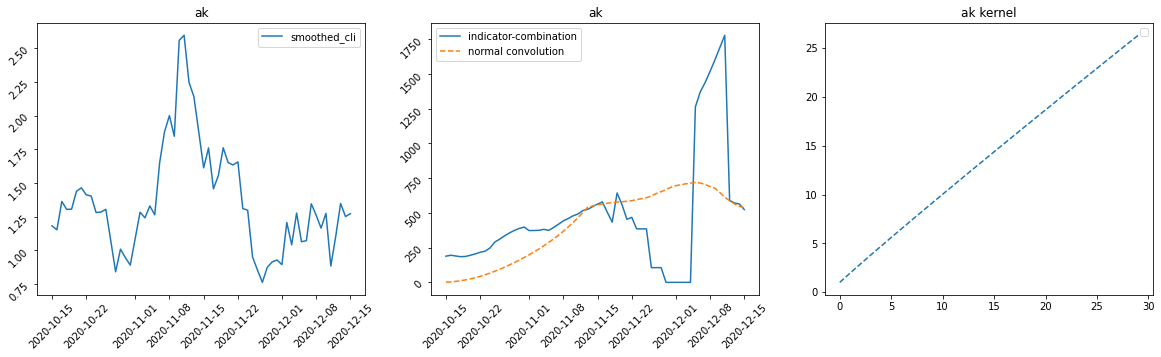

No handles with labels found to put in legend.


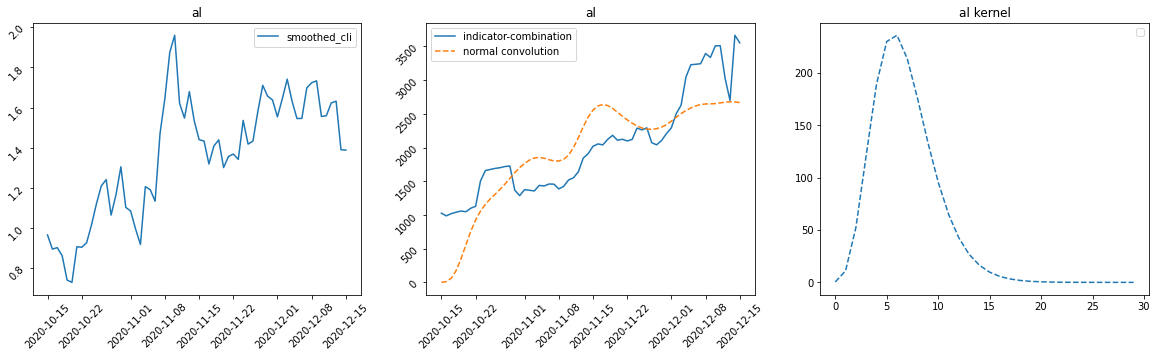

No handles with labels found to put in legend.


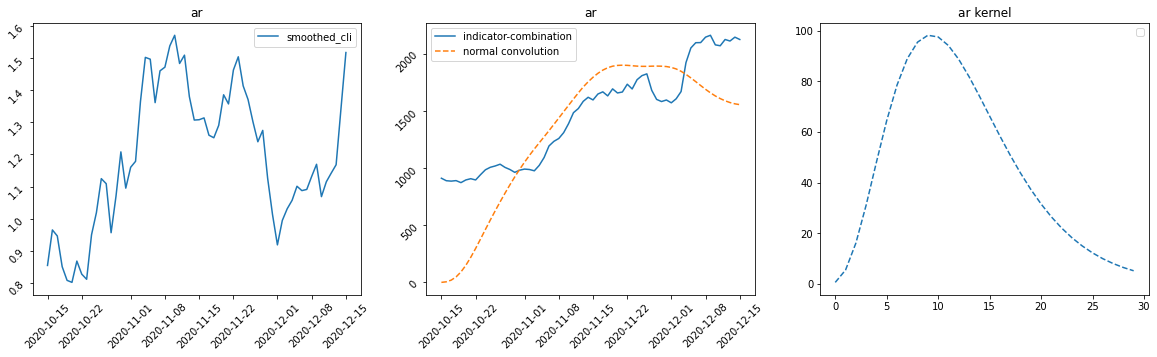

No handles with labels found to put in legend.


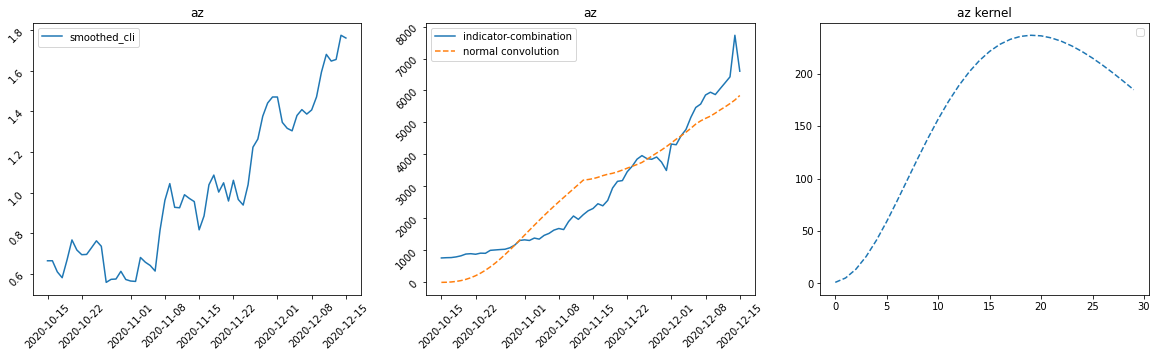

No handles with labels found to put in legend.


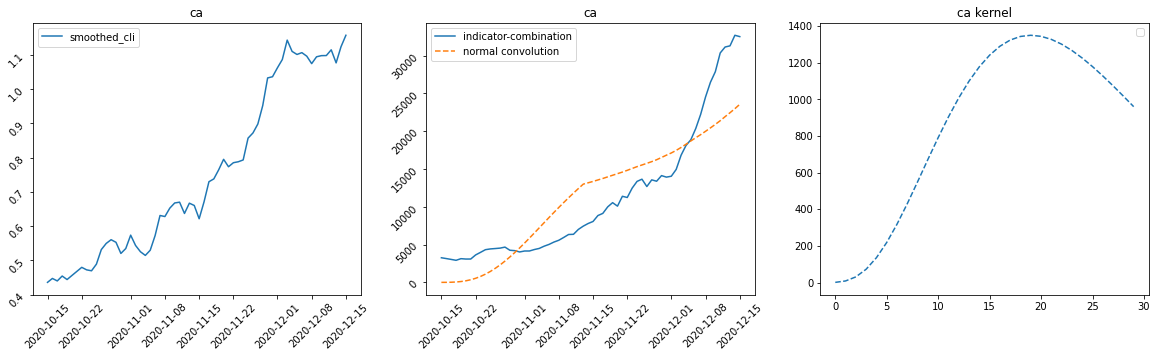

No handles with labels found to put in legend.


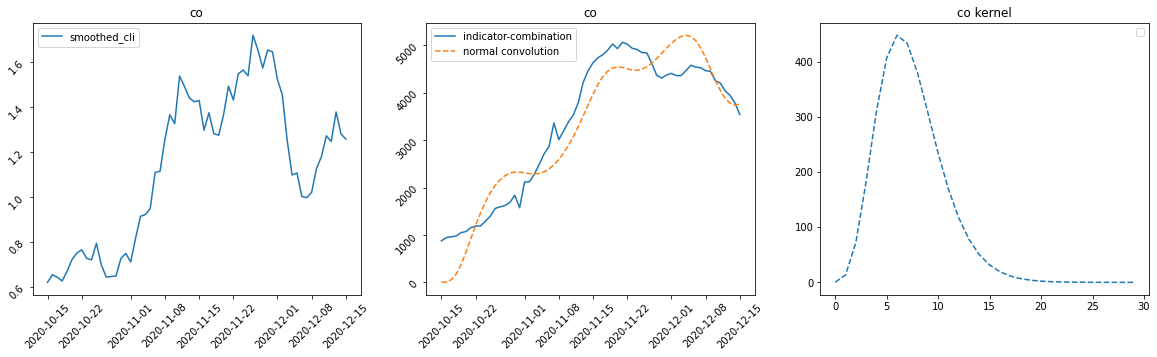

No handles with labels found to put in legend.


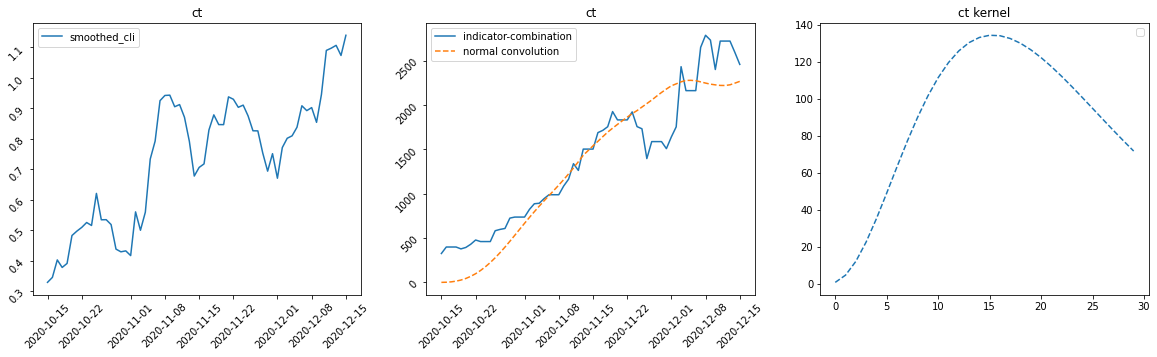

No handles with labels found to put in legend.


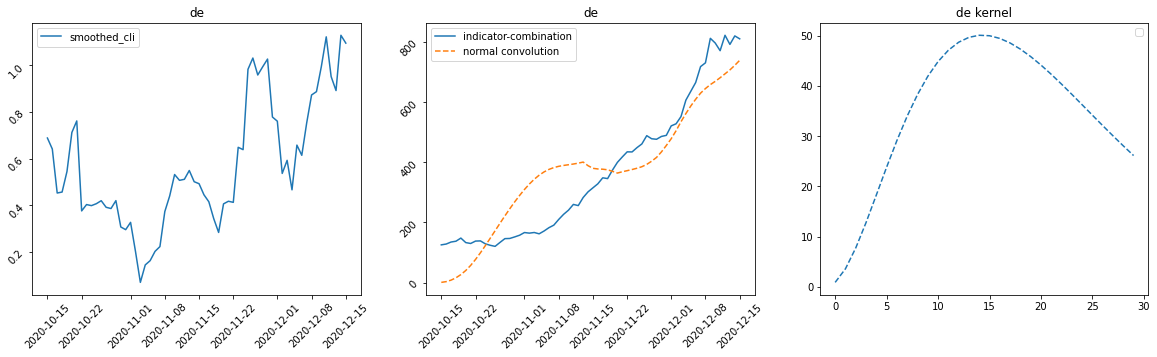

No handles with labels found to put in legend.


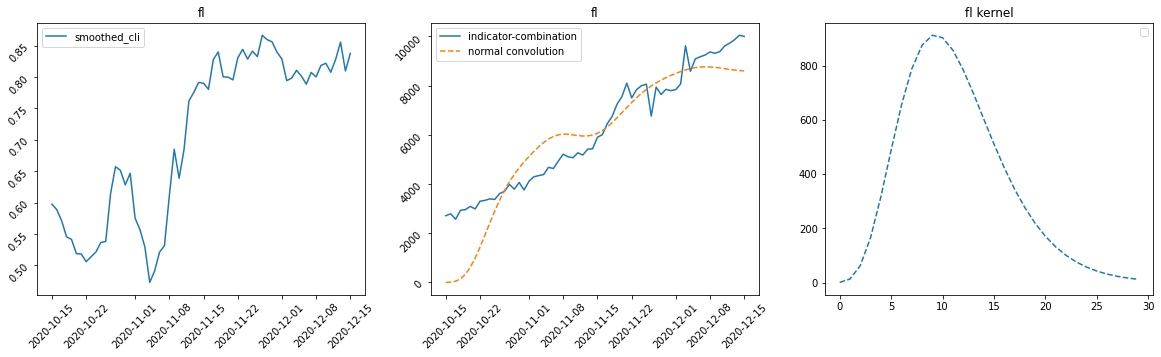

No handles with labels found to put in legend.


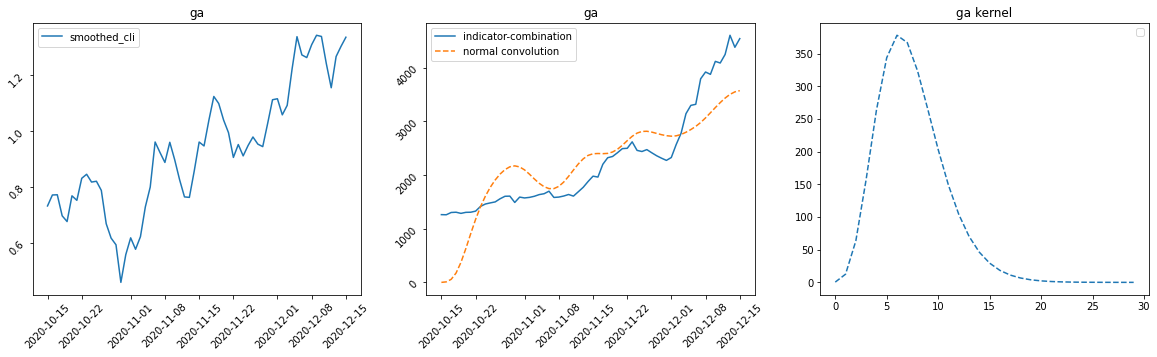

No handles with labels found to put in legend.


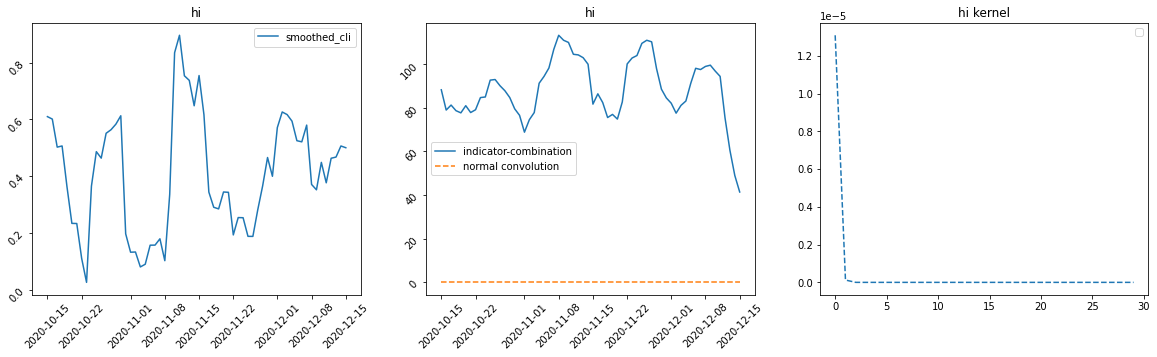

No handles with labels found to put in legend.


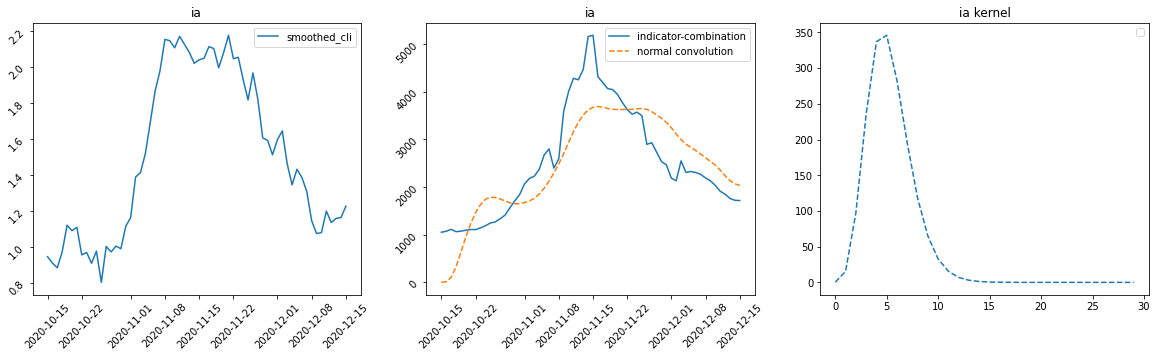

No handles with labels found to put in legend.


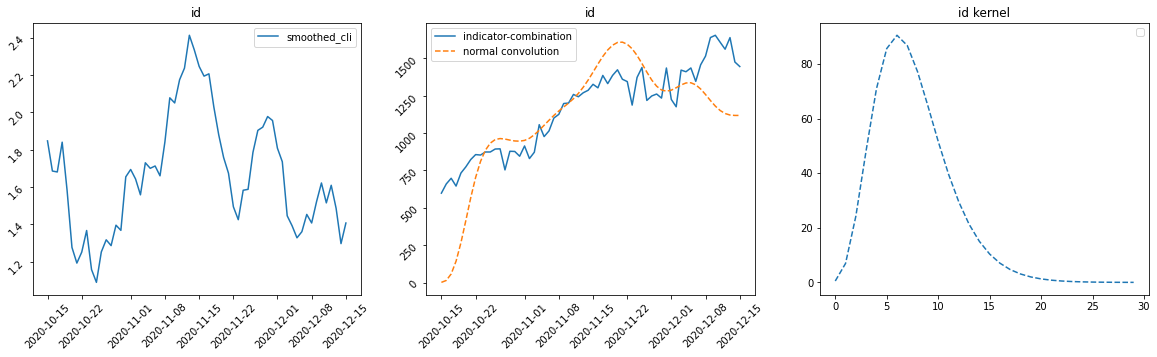

No handles with labels found to put in legend.


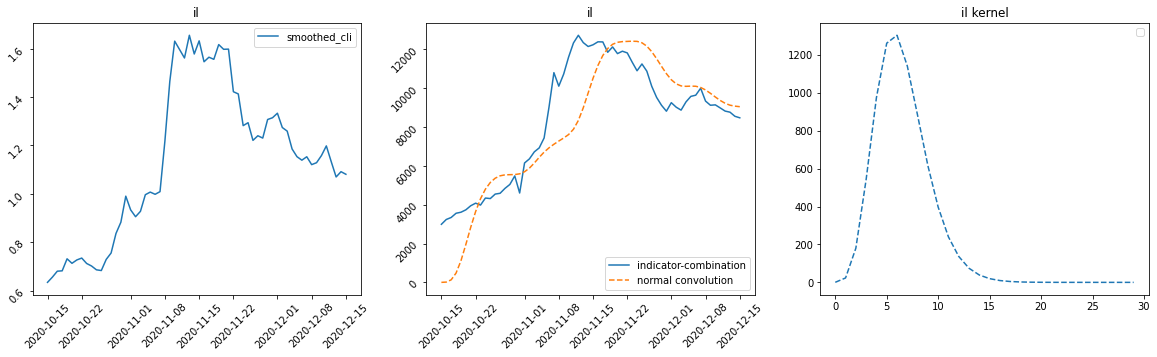

No handles with labels found to put in legend.


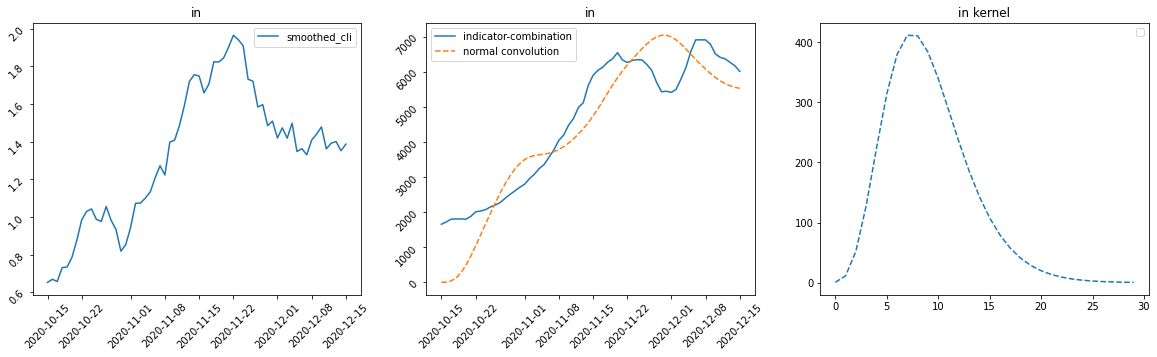

No handles with labels found to put in legend.


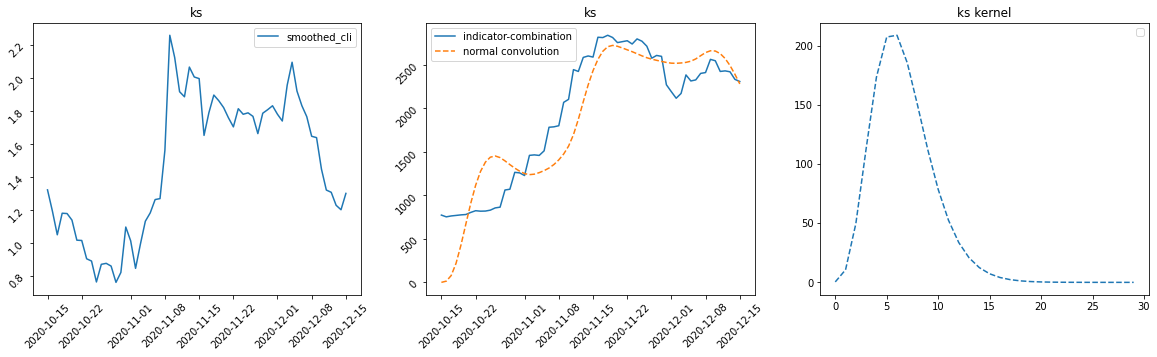

No handles with labels found to put in legend.


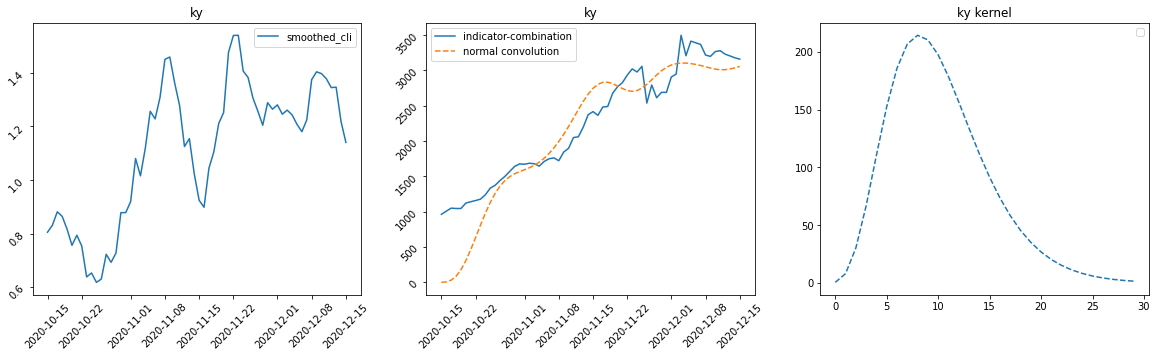

No handles with labels found to put in legend.


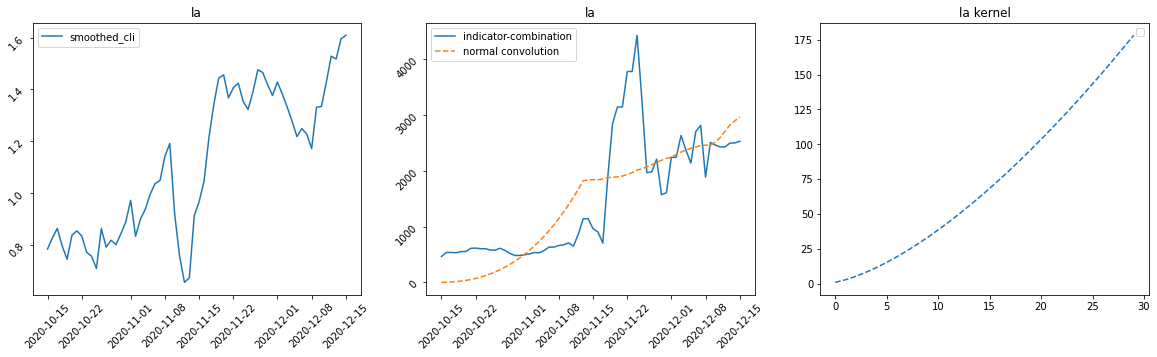

No handles with labels found to put in legend.


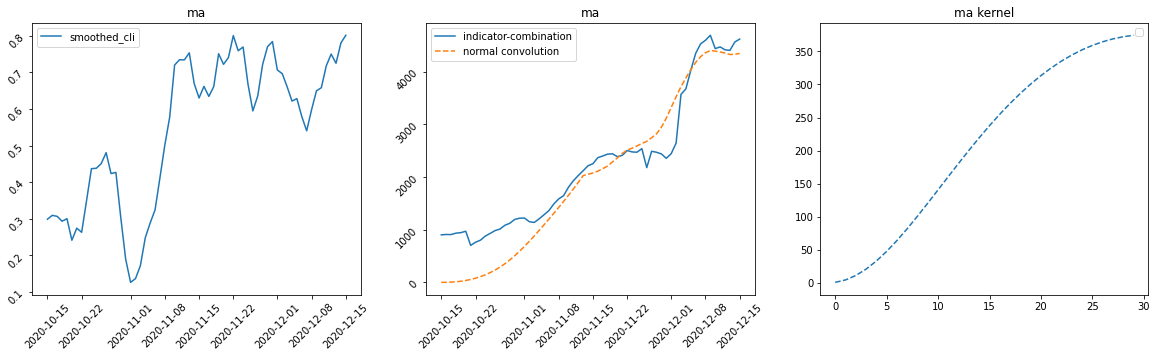

No handles with labels found to put in legend.


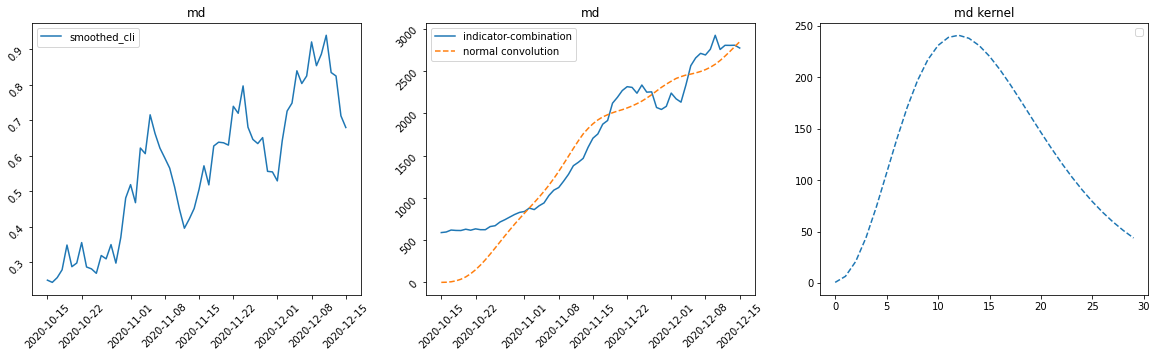

No handles with labels found to put in legend.


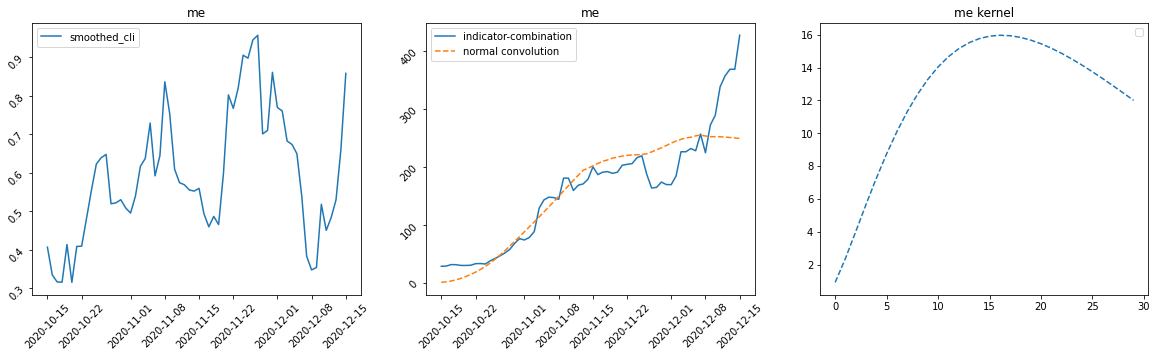

No handles with labels found to put in legend.


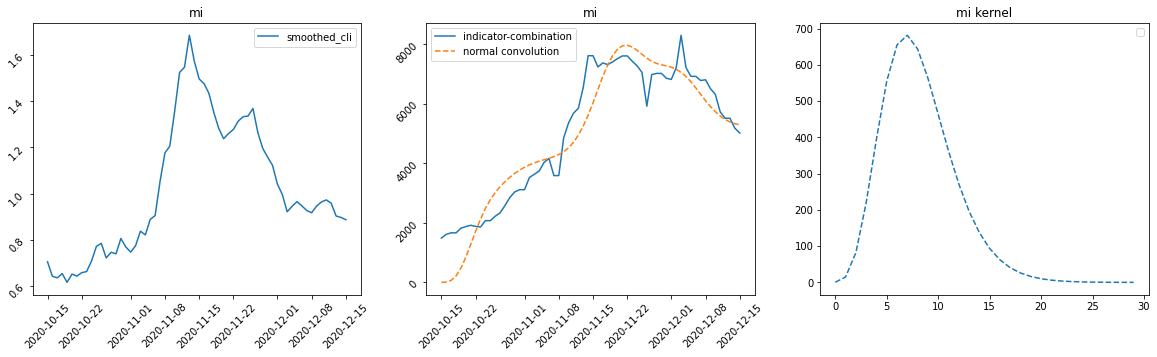

No handles with labels found to put in legend.


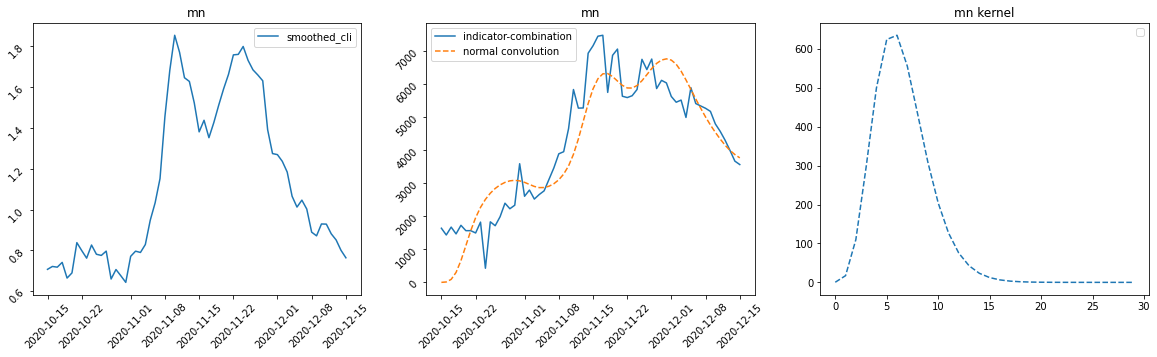

No handles with labels found to put in legend.


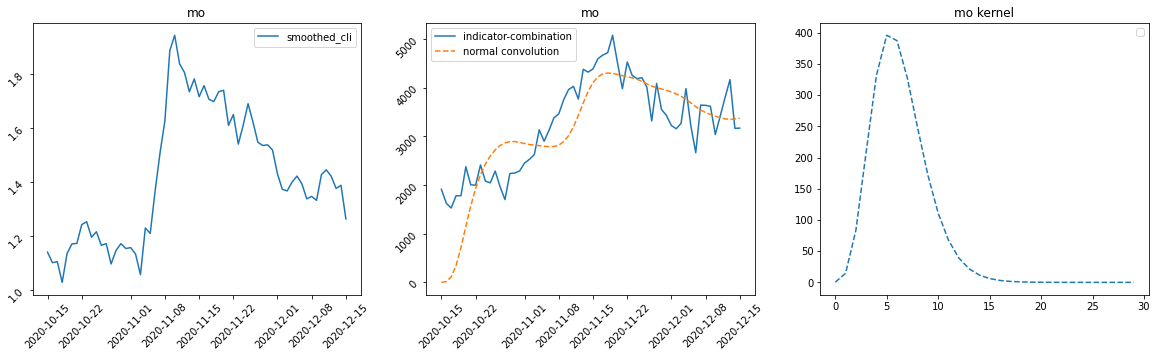

No handles with labels found to put in legend.


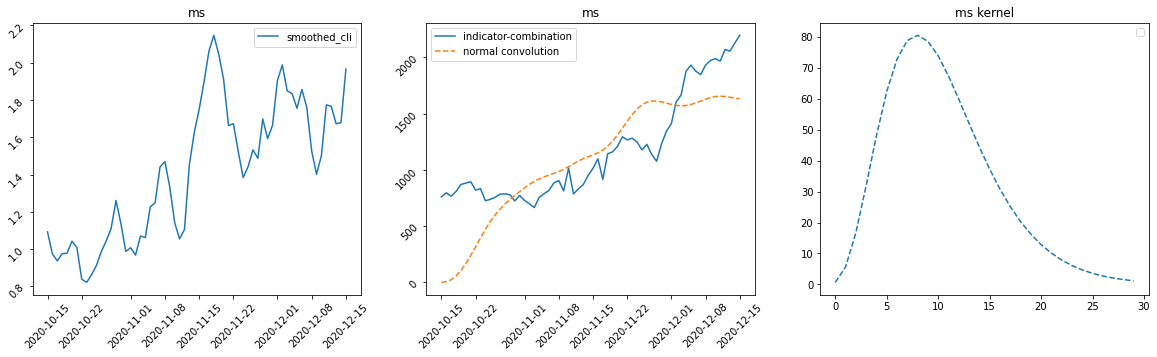

No handles with labels found to put in legend.


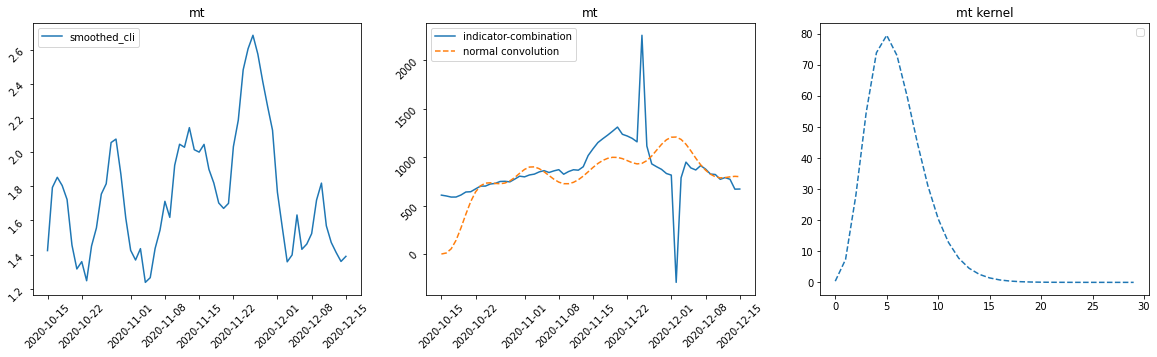

No handles with labels found to put in legend.


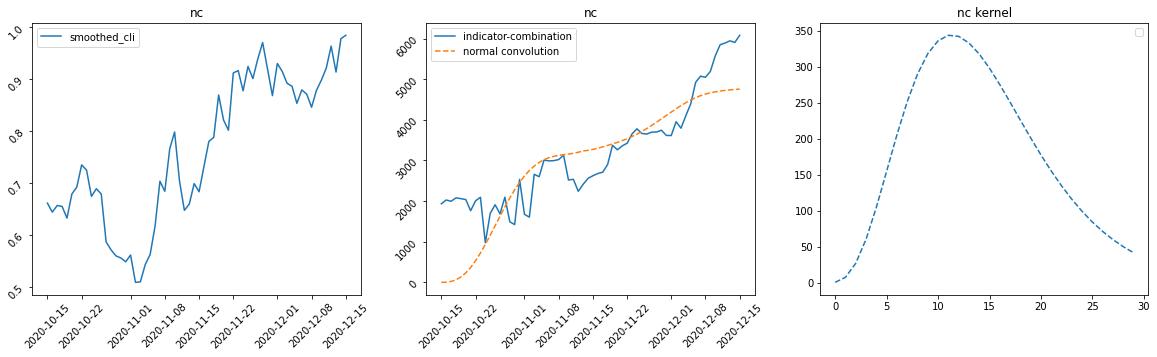

No handles with labels found to put in legend.


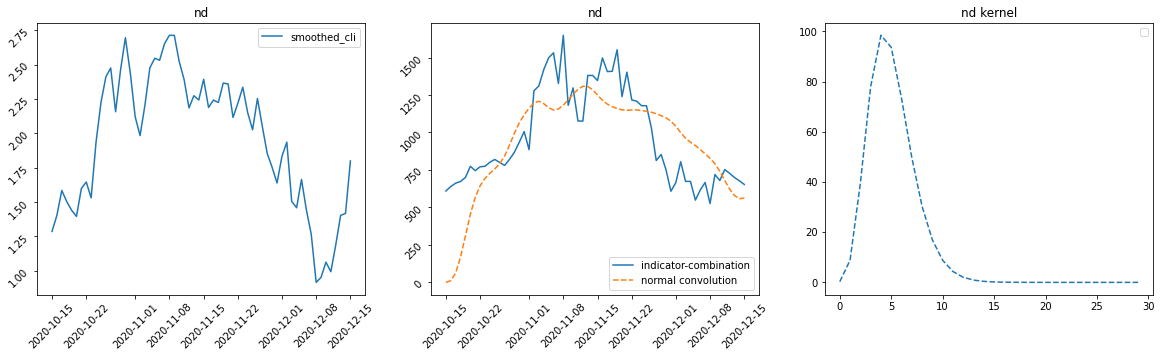

No handles with labels found to put in legend.


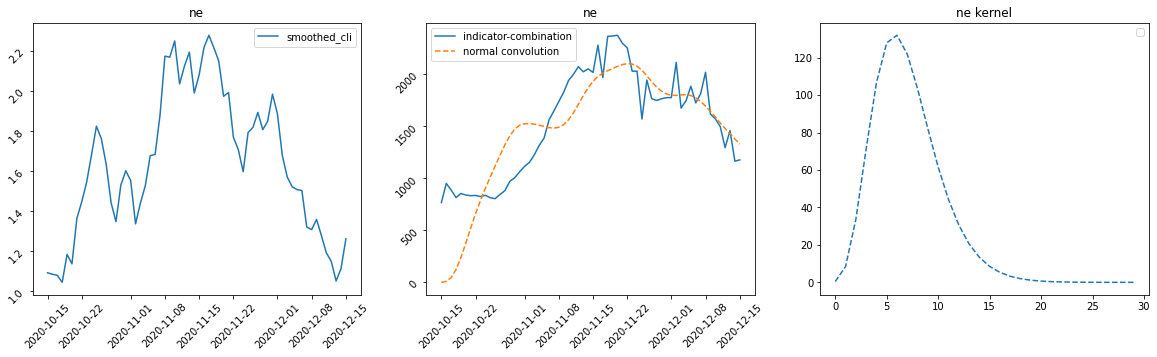

No handles with labels found to put in legend.


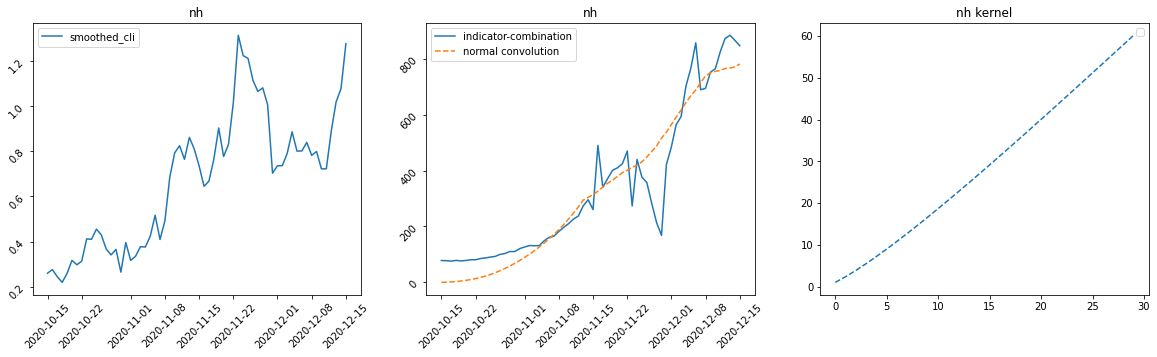

No handles with labels found to put in legend.


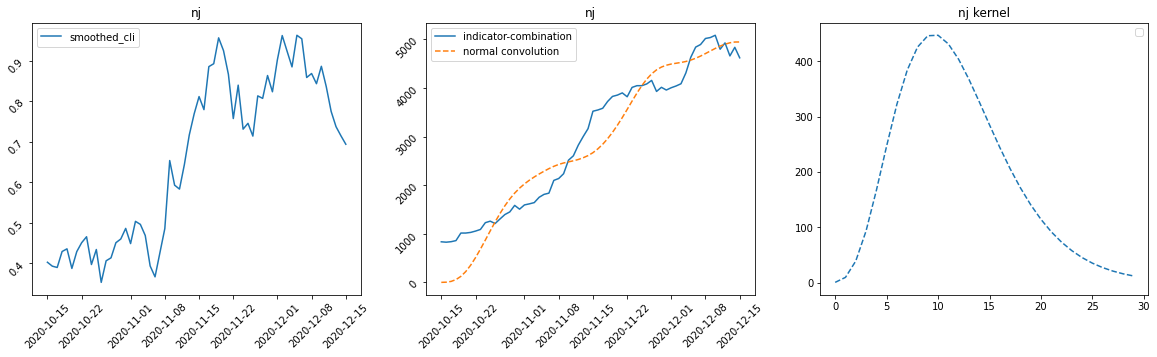

No handles with labels found to put in legend.


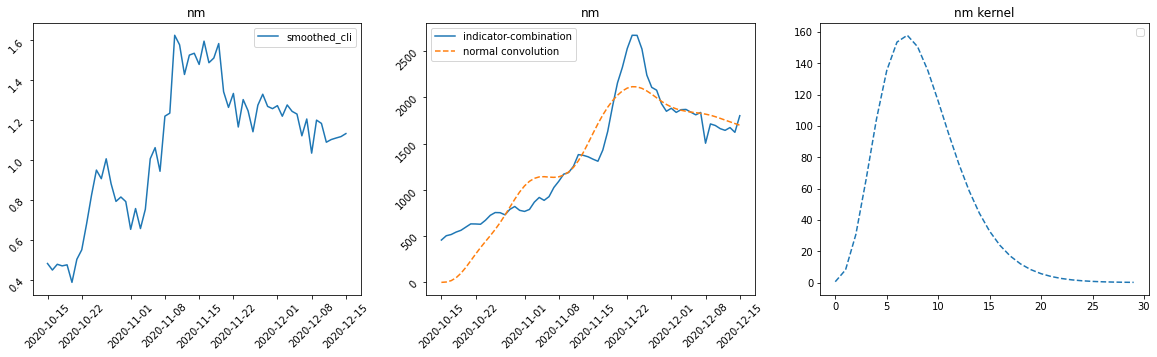

No handles with labels found to put in legend.


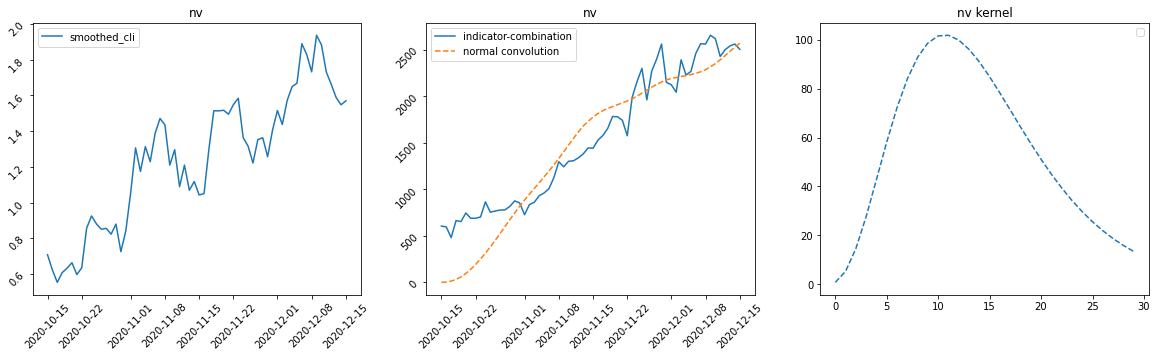

No handles with labels found to put in legend.


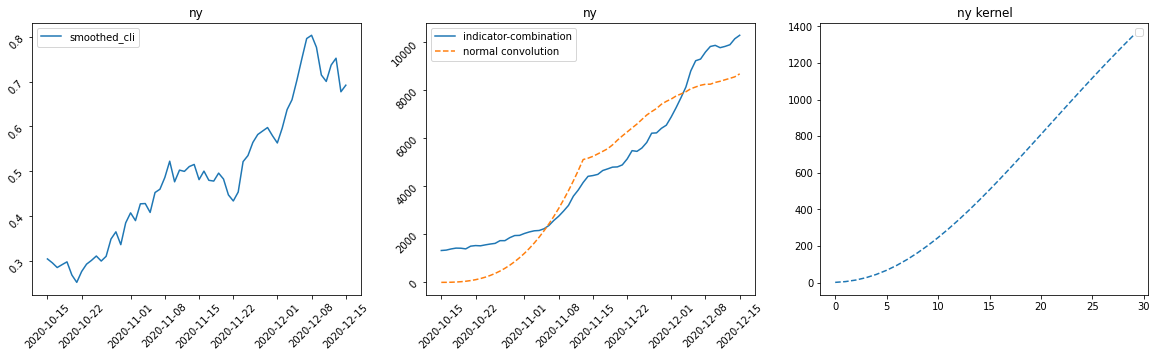

No handles with labels found to put in legend.


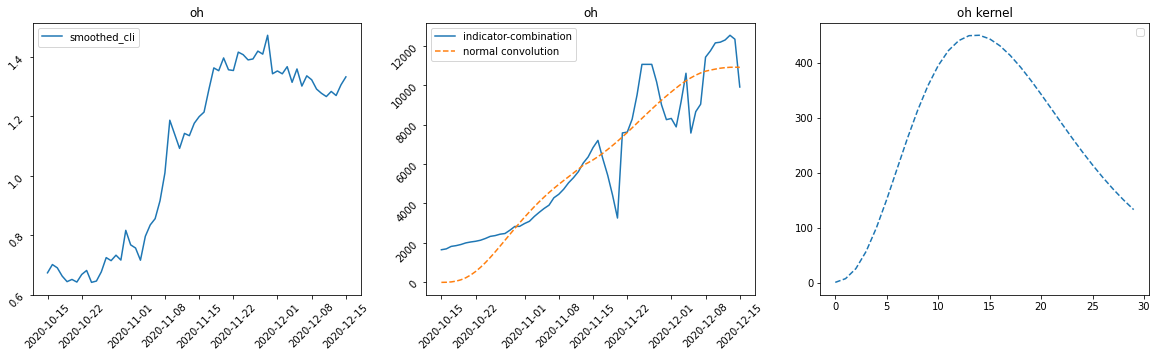

No handles with labels found to put in legend.


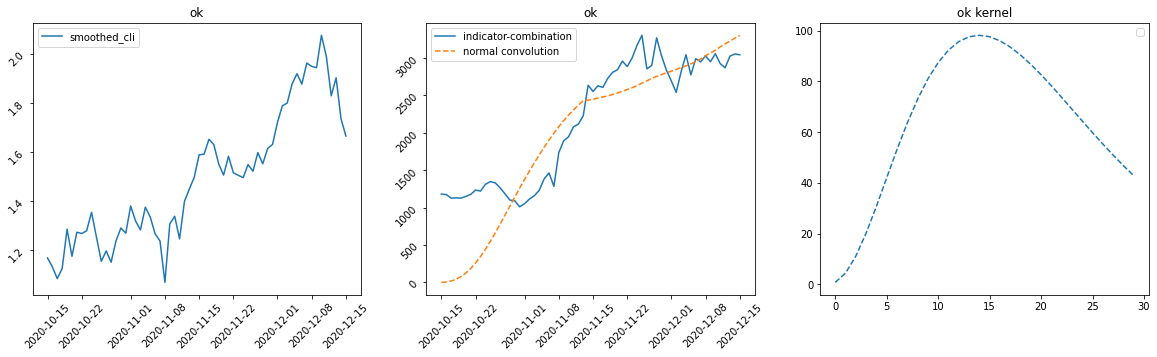

No handles with labels found to put in legend.


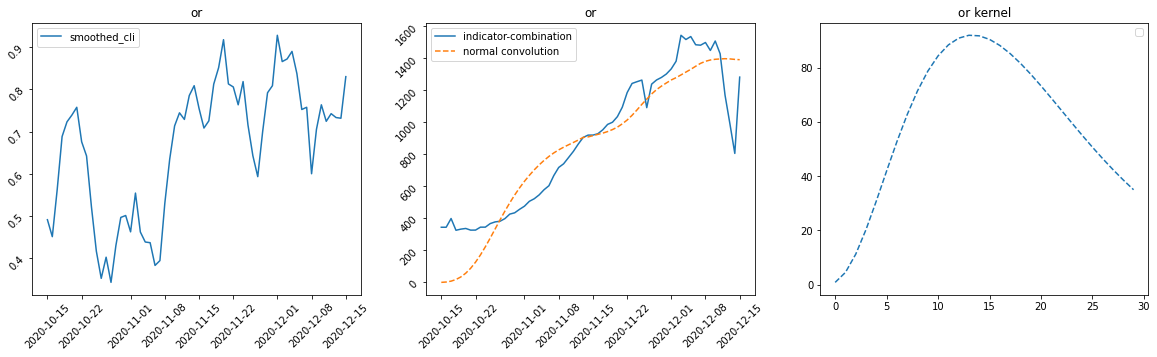

No handles with labels found to put in legend.


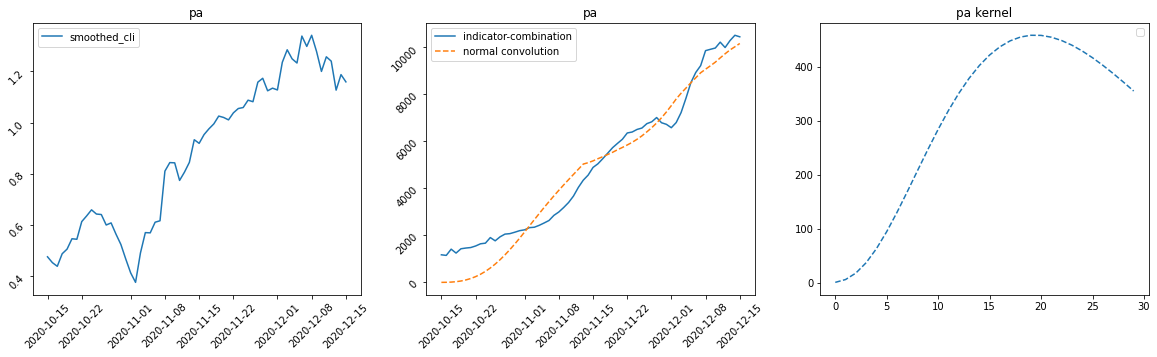

No handles with labels found to put in legend.


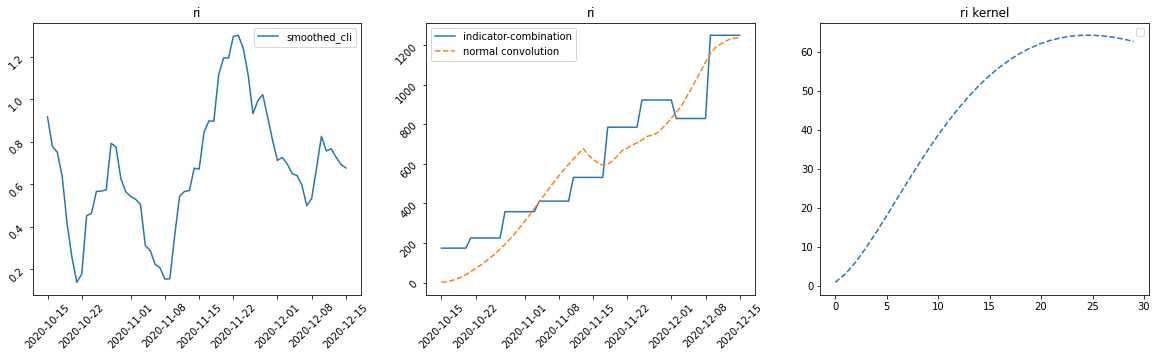

No handles with labels found to put in legend.


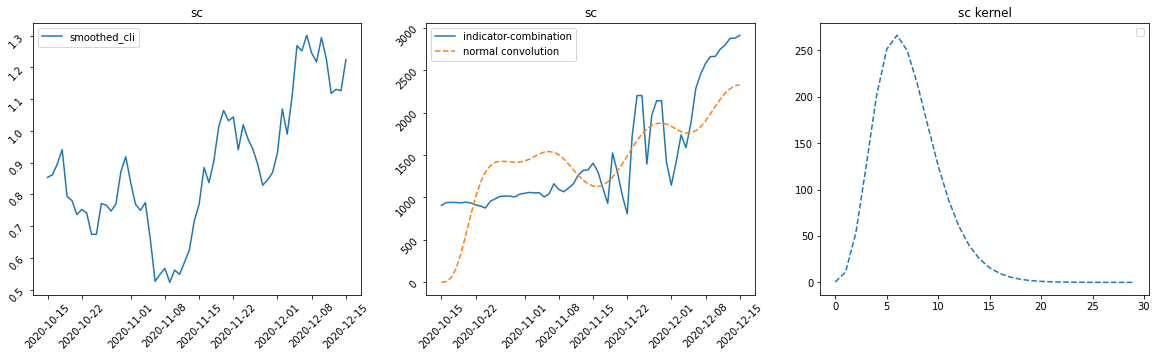

No handles with labels found to put in legend.


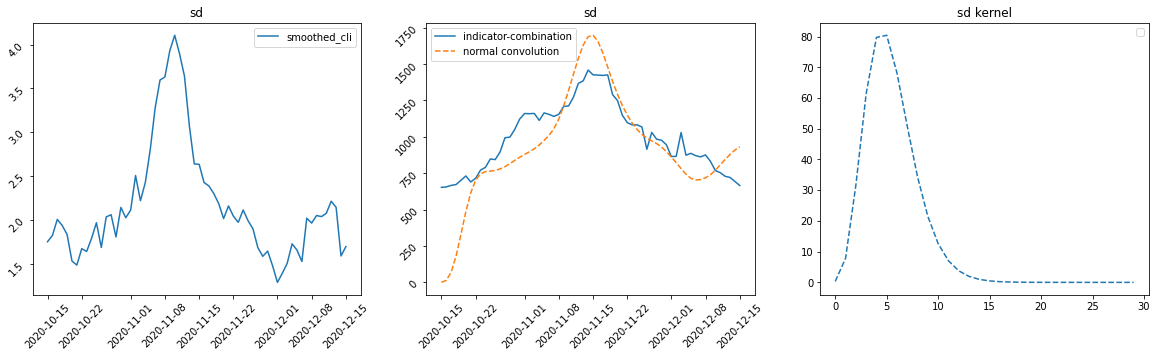

No handles with labels found to put in legend.


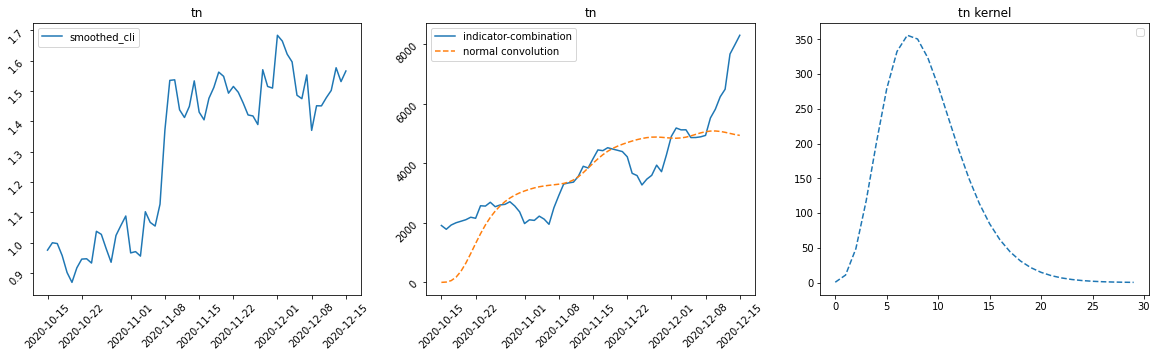

No handles with labels found to put in legend.


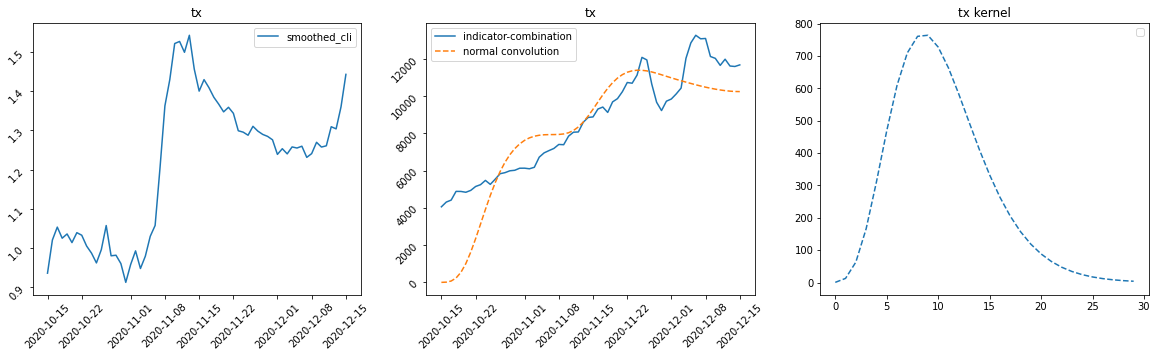

No handles with labels found to put in legend.


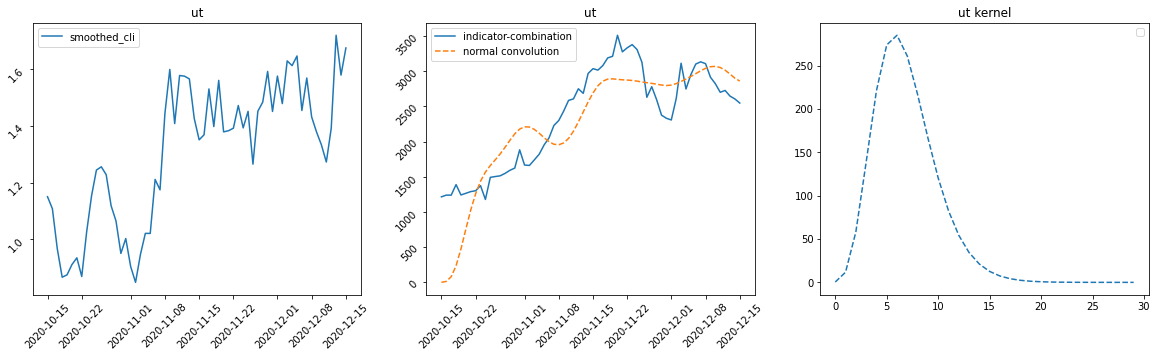

No handles with labels found to put in legend.


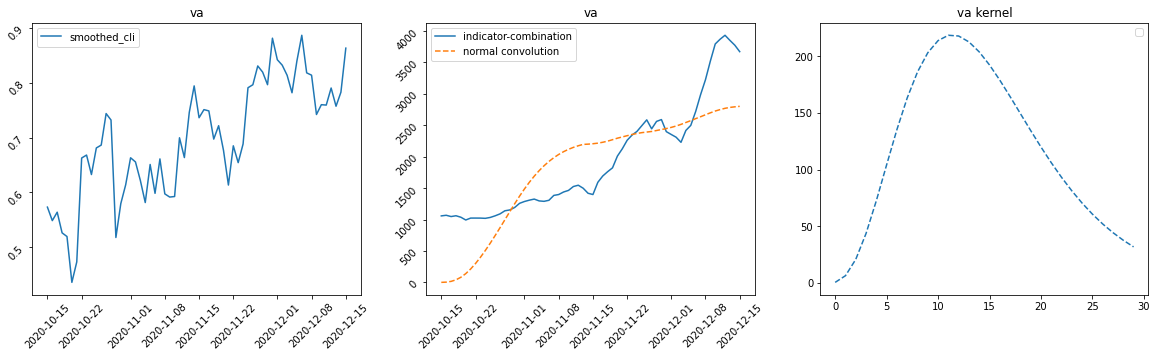

No handles with labels found to put in legend.


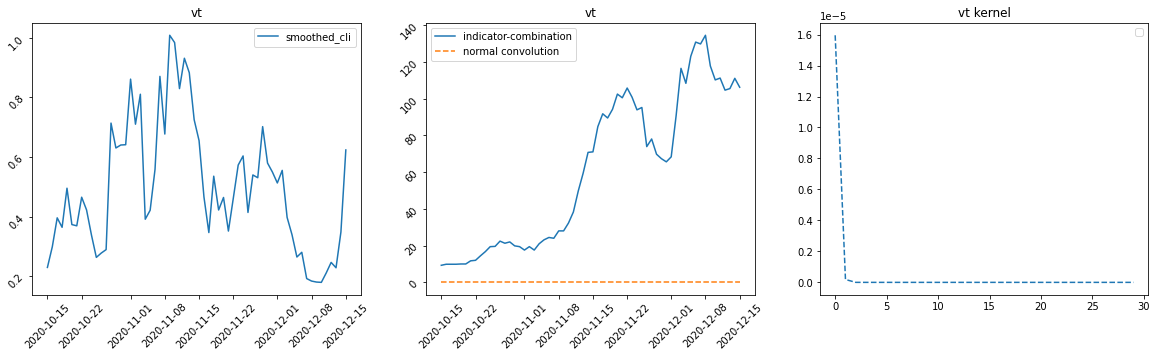

No handles with labels found to put in legend.


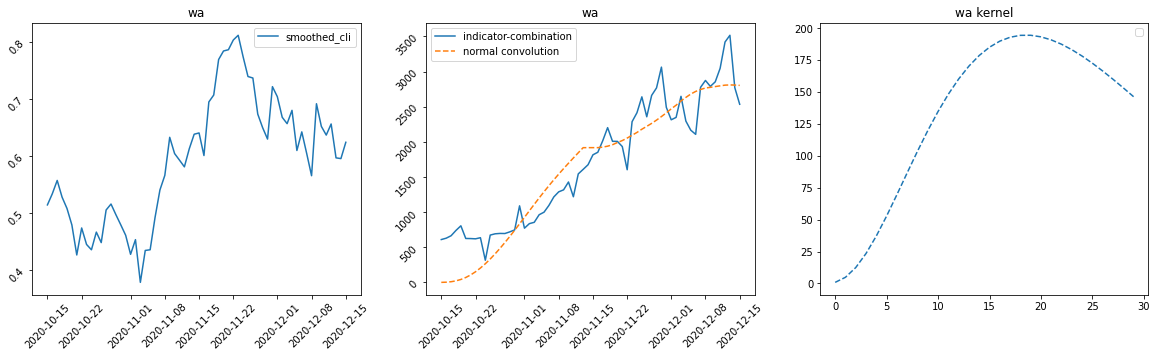

No handles with labels found to put in legend.


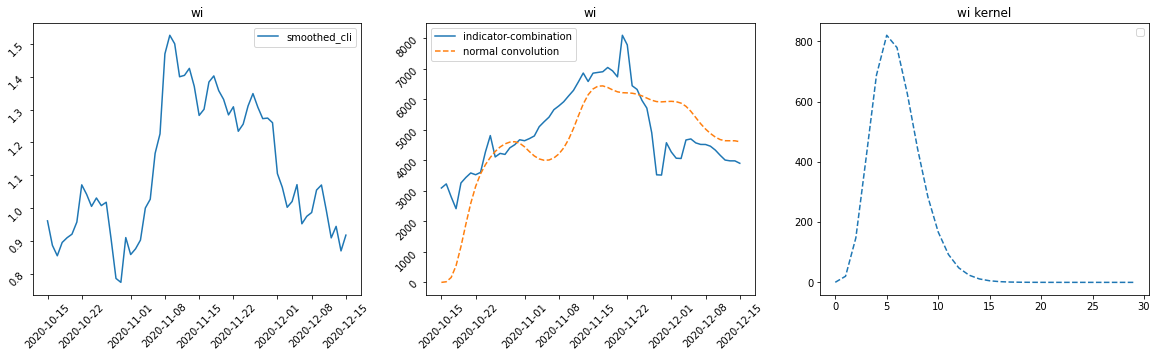

No handles with labels found to put in legend.


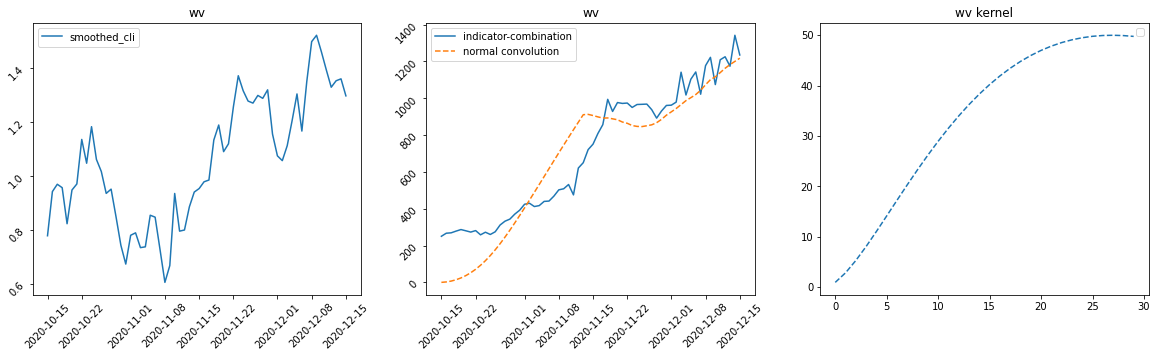

No handles with labels found to put in legend.


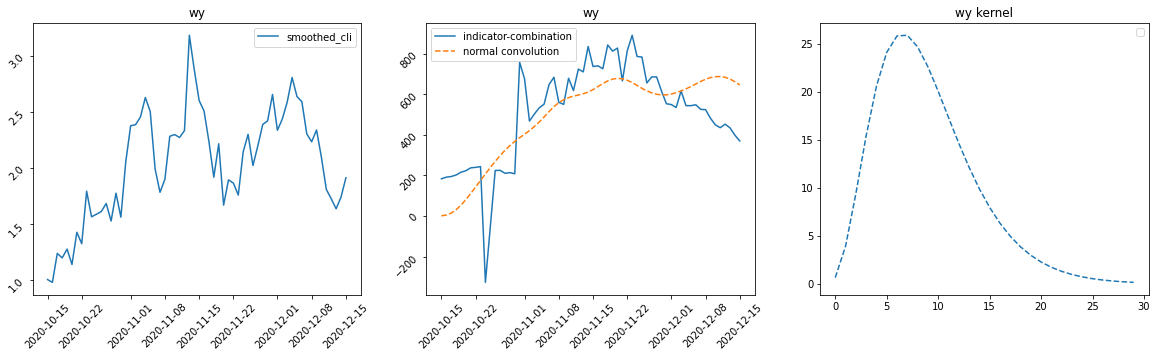

In [7]:
#Evaluation
model_a.load_weights(MODEL_A_PATH).expect_partial() #load best weights from training

dates = X_df['time_value'].sort_values().unique()
X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat_model_a = model_a(X_padded)

for i in range(len(states)):
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat_model_a = Y_hat_model_a[0,:,i]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    ax[0].tick_params(labelrotation=45)
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    #ax[1].plot(dates, y_hat_model_b, label='convolution with filter bank [1,0,0,...]', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    ax[1].tick_params(labelrotation=45)
    
    #ax[2].plot(model_a.trainable_variables[i][::-1,0,0], label='normal convolutional kernel', linestyle='--')
    ax[2].plot(get_kernel(model_a,i)[::-1], linestyle='--')
    #ax[3].plot(get_kernel(model_c,i)[::-1], label='filter bank [1,1,0,...]', linestyle='--')
    ax[2].legend()
    ax[2].set_title('{} kernel'.format(states[i]))
    
    plt.show()